# Group 4 Data Story

This repository contains Group 4's Project 2, focused on vertical mixing shape profile prediction using ocean surface boundary layer information. Our group was interested in two tasks:

1) Learn more about the distribution of input features. We are interested in better understand how different quantities of the input features (like latitude and boundary layer depth) correlate with the shape function across the depth of the profile.
2) Try different model architectures based on what we learned. We tried a number of different machine learning algorithms including: macro + refine, parameter shape, and XGBoost. These profiles allow for more customized learning of different shape functions.

## Setup and Installation

In [1]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests

from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/Ocean mixing new


## Data Loading and Preprocessing

In [3]:
# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 

# Part 1: Interpretability & Input Features

## Latitude Difference

### Input Feature Distributions

Define latitude masks and plot histograms for tropical vs. non-tropical regions:

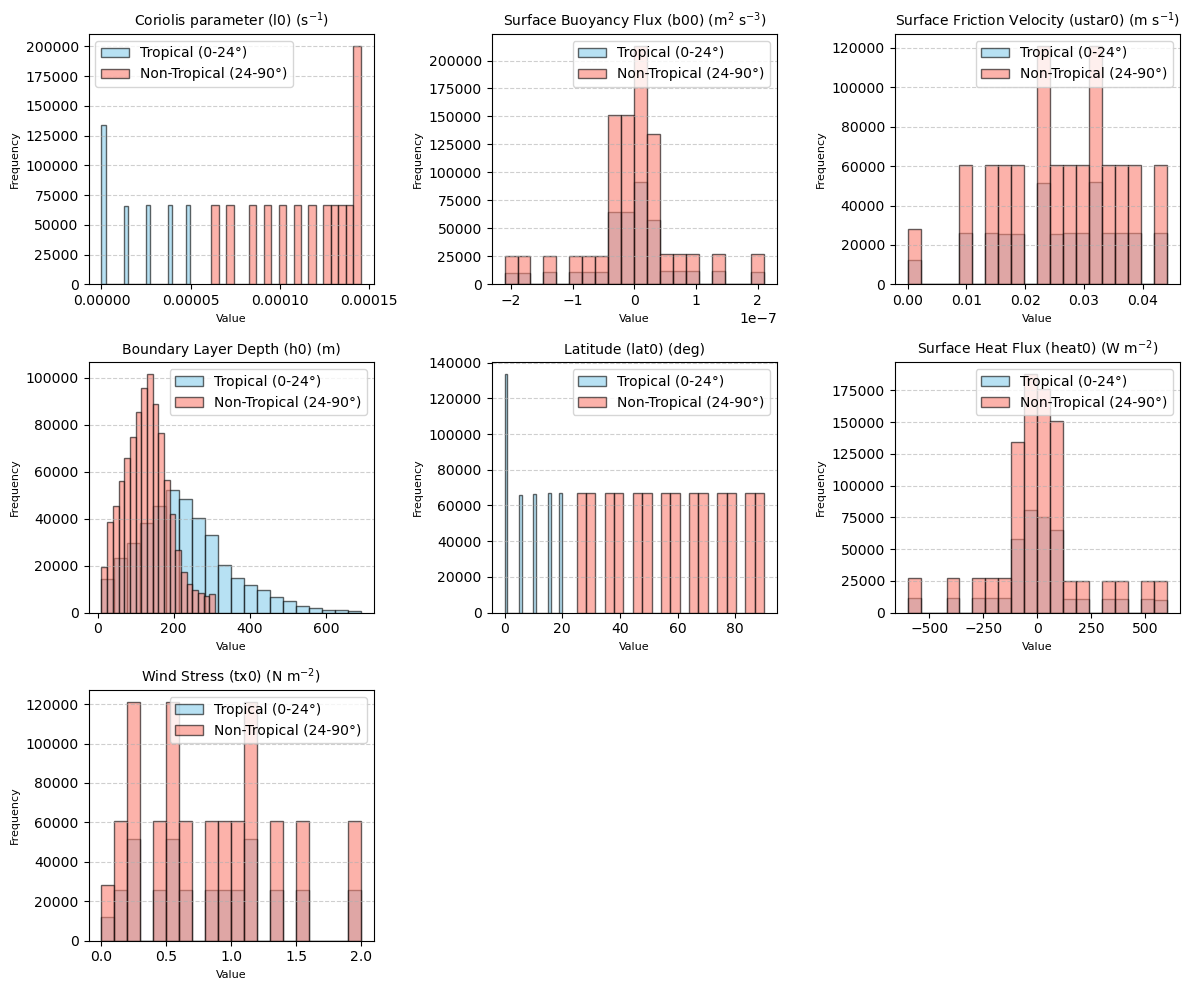

In [5]:
# Define latitude masks
tropical_mask = (lat0.values >= 0) & (lat0.values <= 24)
non_tropical_mask = (lat0.values > 24) & (lat0.values <= 90)

# Define variables for plotting
variables = {
    "Coriolis parameter (l0) (s$^{-1}$)": l0.values,
    "Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": b00.values,
    "Surface Friction Velocity (ustar0) (m s$^{-1}$)": ustar0.values,
    "Boundary Layer Depth (h0) (m)": h0.values,
    "Latitude (lat0) (deg)": lat0.values,
    "Surface Heat Flux (heat0) (W m$^{-2}$)": heat0.values,
    "Wind Stress (tx0) (N m$^{-2}$)": tx0.values,
}

plt.figure(figsize=(12, 10))
for i, (name, data) in enumerate(variables.items()):
    plt.subplot(3, 3, i + 1)
    plt.hist(data[tropical_mask], bins=20, color="skyblue", edgecolor="black", alpha=0.6, label="Tropical (0-24°)")
    plt.hist(data[non_tropical_mask], bins=20, color="salmon", edgecolor="black", alpha=0.6, label="Non-Tropical (24-90°)")
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Correlation Analysis by Latitude Region

Separate data into tropical and non-tropical datasets, compute correlations, and plot heatmaps:

In [6]:
# Build dictionaries for tropical and non-tropical data
data_tropical = {
    "l0": l0[tropical_mask].values,
    "b00": b00[tropical_mask].values,
    "ustar0": ustar0[tropical_mask].values,
    "h0": h0[tropical_mask].values,
    "lat0": lat0[tropical_mask].values,
    "heat0": heat0[tropical_mask].values,
    "tx0": tx0[tropical_mask].values,
}
data_non_tropical = {
    "l0": l0[non_tropical_mask].values,
    "b00": b00[non_tropical_mask].values,
    "ustar0": ustar0[non_tropical_mask].values,
    "h0": h0[non_tropical_mask].values,
    "lat0": lat0[non_tropical_mask].values,
    "heat0": heat0[non_tropical_mask].values,
    "tx0": tx0[non_tropical_mask].values,
}

# Append SF0_1 ... SF0_16 to each dictionary
for i in range(16):
    layer_index = 16 - i - 1
    data_tropical[f"SF0_{i+1}"] = SF0[tropical_mask, layer_index].values.flatten()
    data_non_tropical[f"SF0_{i+1}"] = SF0[non_tropical_mask, layer_index].values.flatten()

# Create DataFrames and compute correlation matrices
df_tropical = pd.DataFrame(data_tropical)
df_non_tropical = pd.DataFrame(data_non_tropical)
corr_tropical = df_tropical.corr()
corr_non_tropical = df_non_tropical.corr()

# Extract correlations for diffusivity (SF0 layers) vs. selected input variables
cols = ["l0", "b00", "ustar0", "h0", "lat0", "heat0", "tx0"]
sf0_corr_tropical = corr_tropical.loc["SF0_1":"SF0_16", cols]
sf0_corr_non_tropical = corr_non_tropical.loc["SF0_1":"SF0_16", cols]


Sum and plot the absolute correlations to compare overall strength:

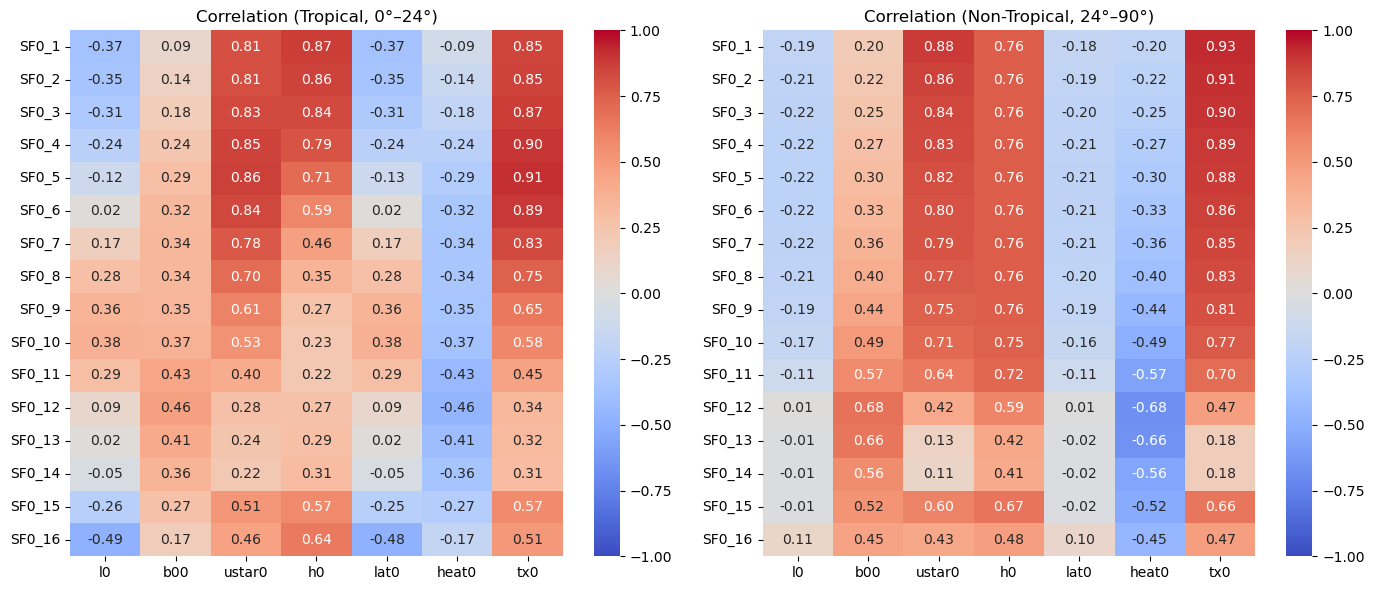

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(sf0_corr_tropical, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, ax=ax1)
ax1.set_title("Correlation (Tropical, 0°–24°)")
sns.heatmap(sf0_corr_non_tropical, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, ax=ax2)
ax2.set_title("Correlation (Non-Tropical, 24°–90°)")
plt.tight_layout()
plt.show()

1. Wind-driven mixing (ustar0 and tx0) dominates in both tropical and non-tropical regions.

2. Boundary layer depth (h0) has stronger correlations in non-tropical waters, likely due to greater variability in deep mixing.

3. Heat flux (heat0) has a much greater influence in non-tropical regions, particularly in deeper layers, likely due to seasonal heat loss driving deep convection.

4. Latitude (lat0) is less important overall, but weakly negative in non-tropical deep layers.

5. Coriolis effects (l0) show moderate negative correlations in the tropics but are weaker in non-tropical waters.


The results suggest that surface processes (wind stress, boundary layer depth) are the primary controls of diffusivity, with heat flux and Coriolis effects playing secondary roles. The biggest differences between the two regions arise in how deep mixing extends—in non-tropical waters, mixing extends deeper due to stronger seasonal variations in heat flux and wind stress.

### Define the Neural Network

In [9]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)
        self.linear2 = nn.Linear(Hid, Hid)
        self.linear3 = nn.Linear(Hid, Out_nodes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        h1 = torch.relu(self.linear1(x))
        h1 = self.dropout(h1)
        h2 = torch.relu(self.linear2(h1))
        h2 = self.dropout(h2)
        y_pred = self.linear3(h2)
        return y_pred


Define the training function:

In [10]:
def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = torch.nn.L1Loss(reduction='mean')
    loss_array = torch.zeros([epochs, 3])
    best_loss = float('inf')
    no_improvement = 0
    best_model_state = None

    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()
            y_pred = model(x)
            valid_pred = model(valid_x)
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)
            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))
            loss.backward()
            optimizer.step()

            loss_array[k, 0] = k  
            loss_array[k, 1] = loss_train.item()  
            loss_array[k, 2] = loss_valid.item()  
            pbar.set_postfix(train_loss=loss_train.item(), valid_loss=loss_valid.item(), patience_count=no_improvement)
            pbar.update(1)

            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()
                no_improvement = 0
                best_model_state = model.state_dict()
            else:
                no_improvement += 1
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}.")
                break
            del loss, y_pred

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model, loss_array[:k, :]


### Data Filtering and NN Training

### Tropical

Apply filtering based on your constraints and prepare the training and validation data:

In [11]:
# Create indices based on defined filters
ind_lat = np.where(tropical_mask)[0]
ind_heat = np.where(np.abs(heat0) < 601)[0]
ind1 = np.intersect1d(ind_lat, ind_heat)
ind2 = np.where(tx0 < 1.2)[0]
ind3 = np.where(h0 > 29)[0]
ind4 = np.where(h0 < 301)[0]
ind5 = np.intersect1d(ind1, ind2)
ind6 = np.intersect1d(ind3, ind5)
ind7 = np.intersect1d(ind4, ind6)

# There are 16 SF0 levels (from bottom to top)
mm1, mm2 = 0, 16
data_load_main = np.zeros([len(h0[ind7]), 4 + (mm2 - mm1)])
data_load_main[:, 0] = l0[ind7]
data_load_main[:, 1] = b00[ind7]
data_load_main[:, 2] = ustar0[ind7]
data_load_main[:, 3] = h0[ind7]
data_load_main[:, 4:(mm2 - mm1 + 4)] = SF0[ind7, mm1:mm2]

data_forc = np.zeros([len(ind7), 3])
data_forc[:, 0] = lat0[ind7]
data_forc[:, 1] = heat0[ind7]
data_forc[:, 2] = tx0[ind7]

data_load3 = copy.deepcopy(data_load_main)

Preprocess the training data and load validation data:

In [12]:
data, x, y, stats, k_mean, k_std = ff.preprocess_train_data(data_load3)

# Load validation data from URL
url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df_valid = pd.read_csv(url, delim_whitespace=True, header=None)
valid_data = df_valid.iloc[:, 3:].values

ind3 = np.where(valid_data[:, 3] > 29)[0]
ind4 = np.where(valid_data[:, 3] < 301)[0]
ind = np.intersect1d(ind3, ind4)
valid_x = valid_data[ind, 0:4]
valid_x[:, 0] = (valid_x[:, 0] - stats[0]) / stats[1]
valid_x[:, 1] = (valid_x[:, 1] - stats[2]) / stats[3]
valid_x[:, 2] = (valid_x[:, 2] - stats[4]) / stats[5]
valid_x[:, 3] = (valid_x[:, 3] - stats[6]) / stats[7]

valid_y = valid_data[ind, 5:]
for i in range(len(valid_y)):
    valid_y[i, :] = np.log(valid_y[i, :] / np.max(valid_y[i, :]))
for i in range(16):
    valid_y[:, i] = (valid_y[:, i] - k_mean[i]) / k_std[i]

# Convert to torch tensors
x = torch.FloatTensor(x).to(device)
y = torch.FloatTensor(y).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)
valid_y = torch.FloatTensor(valid_y).to(device)


Train the model:

In [13]:
epochs, lr = 3000, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16
torch.manual_seed(10)
k_mean_c = torch.tensor(k_mean).float().to(device)
k_std_c = torch.tensor(k_std).float().to(device)
kmask = np.ones(16)  # Or use your custom weights
model = learnKappa_layers(in_nod, hid_nod, o_nod).to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

Training Progress:   2%|▏         | 65/3000 [00:01<00:46, 62.83epoch/s, patience_count=19, train_loss=0.0798, valid_loss=0.182]



Early stopping at epoch 65.


Plot training and validation loss:

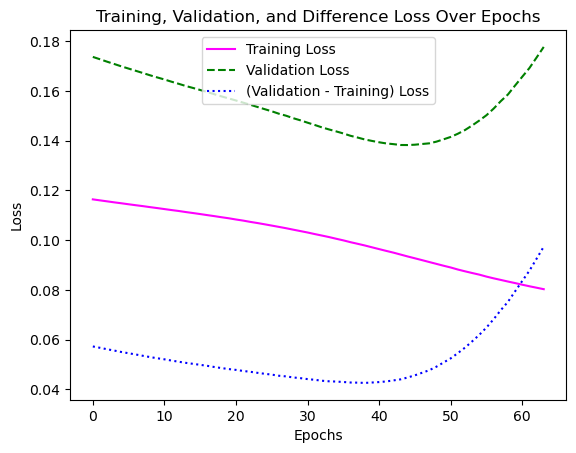

In [14]:
validation_minus_training = loss_array[:, 2] - loss_array[:, 1]
plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss", color="magenta", linestyle="-")
plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss", color="green", linestyle="--")
plt.plot(loss_array[:, 0], validation_minus_training, label="(Validation - Training) Loss", color="blue", linestyle=":")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Difference Loss Over Epochs")
plt.legend()
plt.show()


The plot shows increasing validation loss after ~50 epochs, meaning the model starts to lose generalization ability. Early stopping should be considered.

Evaluate model performance:

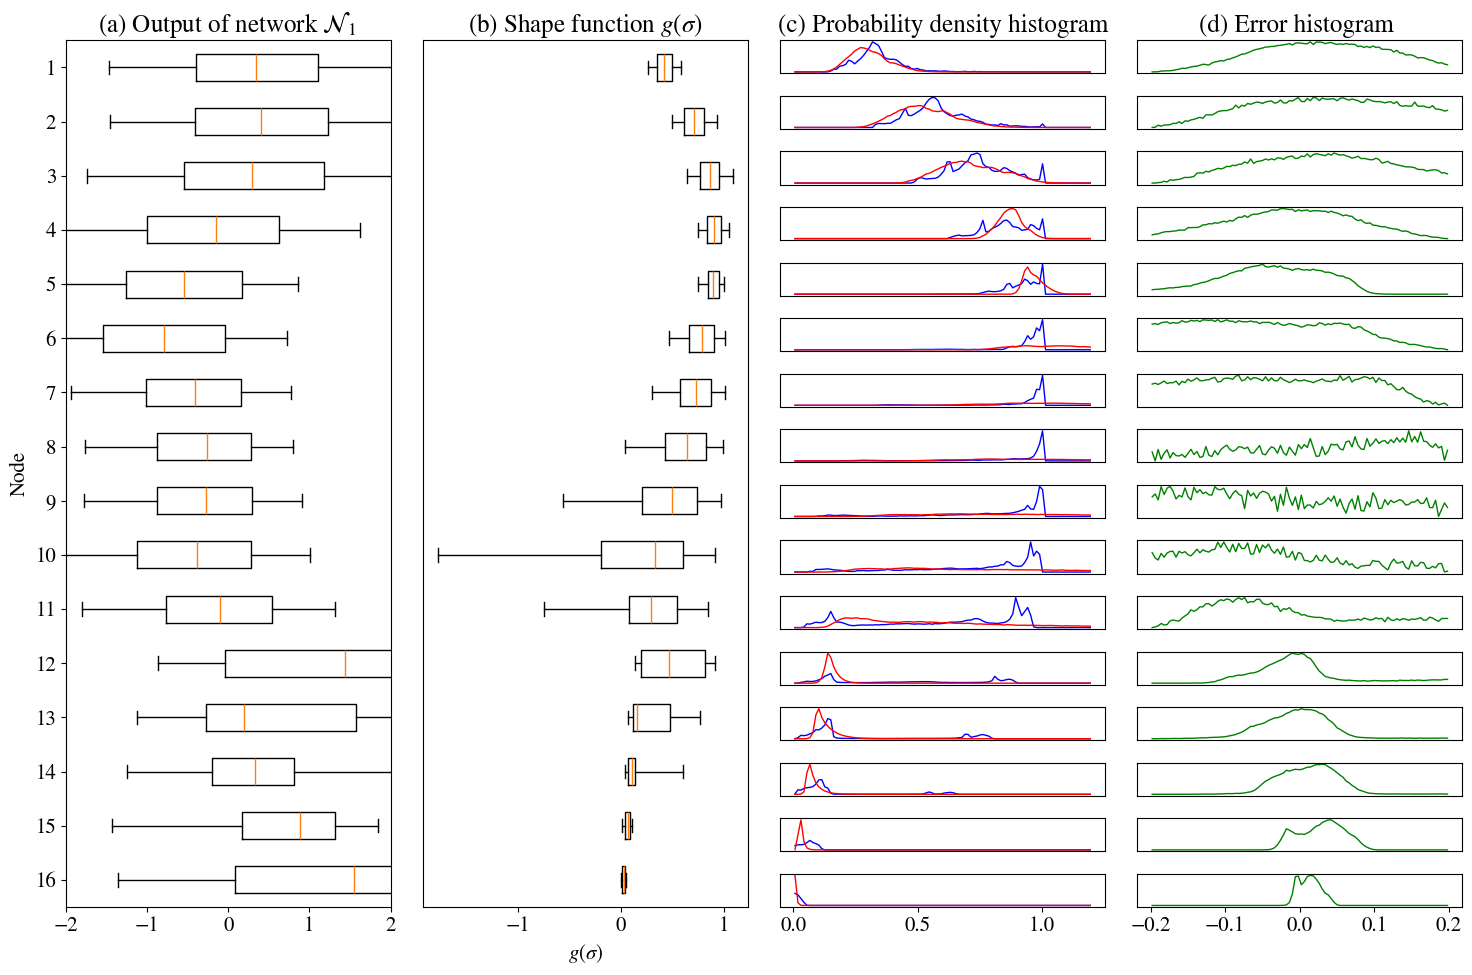

In [15]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

### Non-Tropical

In [16]:
# Create indices based on defined filters
ind_lat = np.where(non_tropical_mask)[0]
ind_heat = np.where(np.abs(heat0) < 601)[0]
ind1 = np.intersect1d(ind_lat, ind_heat)
ind2 = np.where(tx0 < 1.2)[0]
ind3 = np.where(h0 > 29)[0]
ind4 = np.where(h0 < 301)[0]
ind5 = np.intersect1d(ind1, ind2)
ind6 = np.intersect1d(ind3, ind5)
ind7 = np.intersect1d(ind4, ind6)

# There are 16 SF0 levels (from bottom to top)
mm1, mm2 = 0, 16
data_load_main = np.zeros([len(h0[ind7]), 4 + (mm2 - mm1)])
data_load_main[:, 0] = l0[ind7]
data_load_main[:, 1] = b00[ind7]
data_load_main[:, 2] = ustar0[ind7]
data_load_main[:, 3] = h0[ind7]
data_load_main[:, 4:(mm2 - mm1 + 4)] = SF0[ind7, mm1:mm2]

data_forc = np.zeros([len(ind7), 3])
data_forc[:, 0] = lat0[ind7]
data_forc[:, 1] = heat0[ind7]
data_forc[:, 2] = tx0[ind7]

data_load3 = copy.deepcopy(data_load_main)

In [17]:
data, x, y, stats, k_mean, k_std = ff.preprocess_train_data(data_load3)

# Load validation data from URL
url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df_valid = pd.read_csv(url, delim_whitespace=True, header=None)
valid_data = df_valid.iloc[:, 3:].values

ind3 = np.where(valid_data[:, 3] > 29)[0]
ind4 = np.where(valid_data[:, 3] < 301)[0]
ind = np.intersect1d(ind3, ind4)
valid_x = valid_data[ind, 0:4]
valid_x[:, 0] = (valid_x[:, 0] - stats[0]) / stats[1]
valid_x[:, 1] = (valid_x[:, 1] - stats[2]) / stats[3]
valid_x[:, 2] = (valid_x[:, 2] - stats[4]) / stats[5]
valid_x[:, 3] = (valid_x[:, 3] - stats[6]) / stats[7]

valid_y = valid_data[ind, 5:]
for i in range(len(valid_y)):
    valid_y[i, :] = np.log(valid_y[i, :] / np.max(valid_y[i, :]))
for i in range(16):
    valid_y[:, i] = (valid_y[:, i] - k_mean[i]) / k_std[i]

# Convert to torch tensors
x = torch.FloatTensor(x).to(device)
y = torch.FloatTensor(y).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)
valid_y = torch.FloatTensor(valid_y).to(device)


Train the Neural Network

In [18]:
epochs, lr = 3000, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16
torch.manual_seed(10)
k_mean_c = torch.tensor(k_mean).float().to(device)
k_std_c = torch.tensor(k_std).float().to(device)
kmask = np.ones(16)  # Or use your custom weights
model = learnKappa_layers(in_nod, hid_nod, o_nod).to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

Training Progress:  35%|███▍      | 1041/3000 [00:25<00:48, 40.04epoch/s, patience_count=19, train_loss=0.0262, valid_loss=0.057] 



Early stopping at epoch 1041.


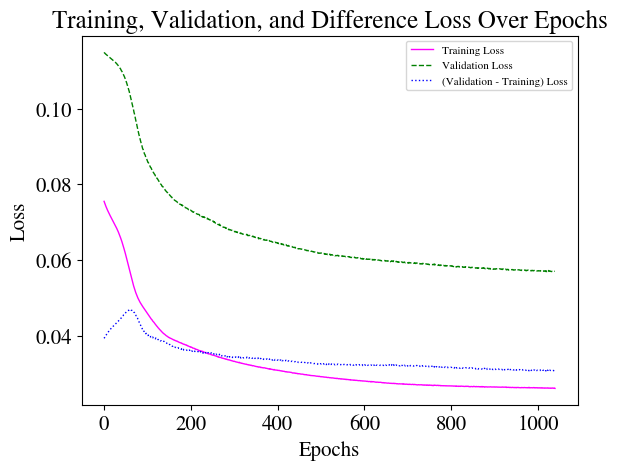

In [19]:
validation_minus_training = loss_array[:, 2] - loss_array[:, 1]
plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss", color="magenta", linestyle="-")
plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss", color="green", linestyle="--")
plt.plot(loss_array[:, 0], validation_minus_training, label="(Validation - Training) Loss", color="blue", linestyle=":")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Difference Loss Over Epochs")
plt.legend()
plt.show()


Unlike the tropical case, where overfitting occurred after ~50 epochs, the training loss here continues to decrease steadily, suggesting a well-behaved training process.

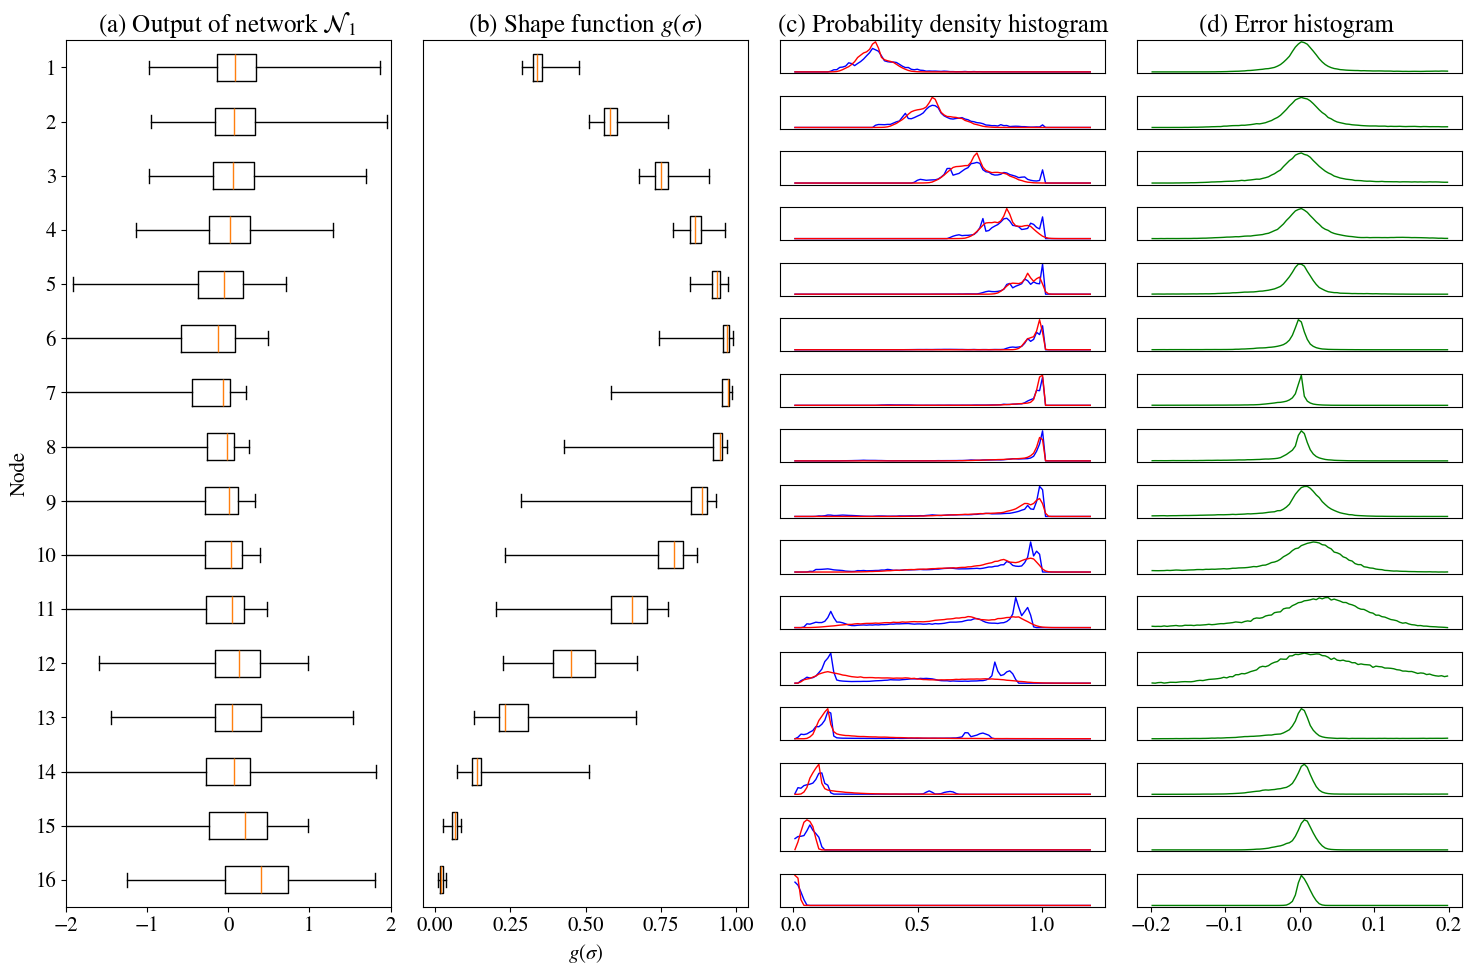

In [20]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)


The predicted shape of Shape function 𝑔(𝜎) appear to align more closely with the actual shape compared to the tropical region.

Why Does the Model Perform Better in Non-Tropical Regions?

1. More Structured Mixing Processes

- In higher latitudes, seasonal variations lead to stronger mixing events (e.g., winter convection), creating more distinct patterns in the shape function.

- The model can learn these structured patterns more effectively.

2. Tropical Mixing is More Complex

- Tropical diffusivity is influenced by surface-driven turbulence, wind stress, and weaker stratification effects, which vary significantly.

- These complex interactions make it harder for the model to generalize across different profiles.

## Boundary Layer Depth

Sane et al. (2023) found that the bias between the mixed layer depths from their neural network parametrization and the physics-based parametrization was higher in winter than spring, which corresponds to deeper mixed layers. This finding, that bias is higher with deep mixed layers, indicates there are more complicated processes at work during winter when convection can occur due to weaker stratification.

Below we calculate the correlation between our input variables (Coriolis parameter, surface bouyancy flux, surface friction velocity, and boundary layer depth) and the diffusivity shape function they correspond to based on different boundary layer depths.

In [4]:
#this function takes an upper and lower depth boundary and filters the data to only those depths
#then it computes the correlation matrix between the 4 input variables (lat, bouyancy, velocity, and depth) and each point of the shape function
def correlation_by_depth(depth_min, depth_max):
    d_depth = d.where((d.h.compute() < depth_max) & (d.h.compute() > depth_min), drop=True)
    l0_depth    =corio(d_depth['l'][:])
    b00_depth   =d_depth['b0'][:]
    ustar0_depth=d_depth['ustar'][:]
    h0_depth    =d_depth['h'][:]
    lat0_depth  =d_depth['lat'][:]
    heat0_depth =d_depth['heat'][:]
    tx0_depth   =d_depth['tx'][:] 
    tx0_depth   =np.round(tx0_depth,2)
    SF0_depth   =d_depth['SF'][:] 
    
    data_depth = {
        "l0": l0_depth.values.flatten(),
        "b00": b00_depth.values.flatten(),
        "ustar0": ustar0_depth.values.flatten(),
        "h0": h0_depth.values.flatten(),
    }
    
    for i in range(16):
        data_depth[f"SF0_{i+1}"] = SF0_depth[:, 16-i-1].values.flatten()
    
    df_depth = pd.DataFrame(data_depth)
    correlation_matrix_depth = df_depth.corr()
    sf0_correlation_depth = correlation_matrix_depth.loc["SF0_1":"SF0_16", ["l0", "b00", "ustar0", "h0"]]

    return sf0_correlation_depth

In [5]:
#select depth ranges)
bins = [0,25,50,700]

In [6]:
#compute correlation matrix for a certain depth range
correlation_0_25 = correlation_by_depth(bins[0],bins[1])
correlation_0_50 = correlation_by_depth(bins[0],bins[2])
correlation_50_700 = correlation_by_depth(bins[2],bins[3])
correlation_0_700 = correlation_by_depth(bins[0],bins[3])

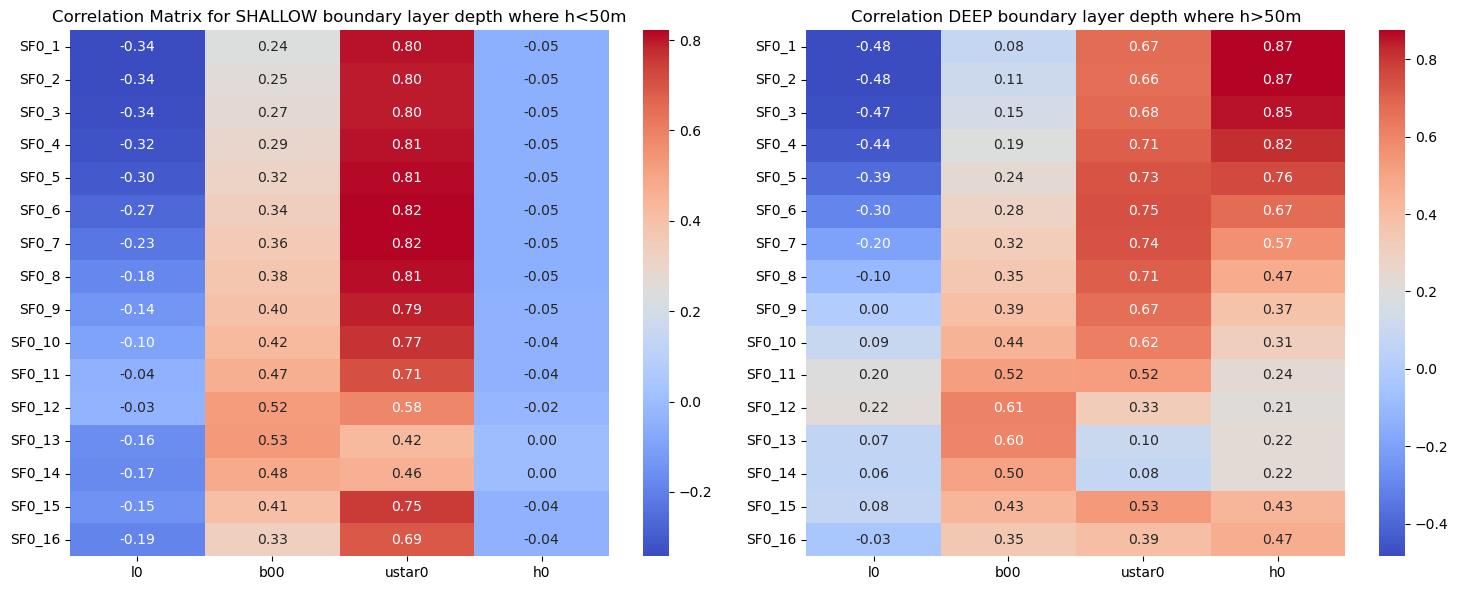

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(correlation_0_50, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=axs[0])
axs[0].set_title("Correlation Matrix for SHALLOW boundary layer depth where h<{}m".format(bins[2]))

sns.heatmap(correlation_50_700, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=axs[1])
axs[1].set_title("Correlation DEEP boundary layer depth where h>{}m".format(bins[2]))

plt.tight_layout()
plt.show()

The plots above show the correlation matrices for the dataset filtered in 2 ways: only the data with boundary layers less than 50m and only the data with boundary layers greater than 50m. Some of the correlations look fairly similar between the two. Bouyancy flux for example has visually very similar correlations. For shallow boundary layers, the boundary layer input has little correlation which makes sense (because we've chosen similar regimes), however for deep boundary layers there is higher correlation, likely because there is a larger range of h values. Latitude and velocity both have similar patterns in correlation, just shifted slightly (shallow boundary layers have higher correlation for velocity and lower for latitude).

These plots can be complicated to interpret because there are many values to look at. In order to simplify, we added the (absolute value of) correlation for each depth point across all four inputs to compare the overall strength of correlation for each point across different boundary layer depth regimes.

In [8]:
correlation_0_25_sum = correlation_0_25.abs().sum(axis=1)
correlation_0_50_sum = correlation_0_50.abs().sum(axis=1)
correlation_50_700_sum = correlation_50_700.abs().sum(axis=1)
correlation_0_700_sum = correlation_0_700.abs().sum(axis=1)
y = np.arange(1,17)

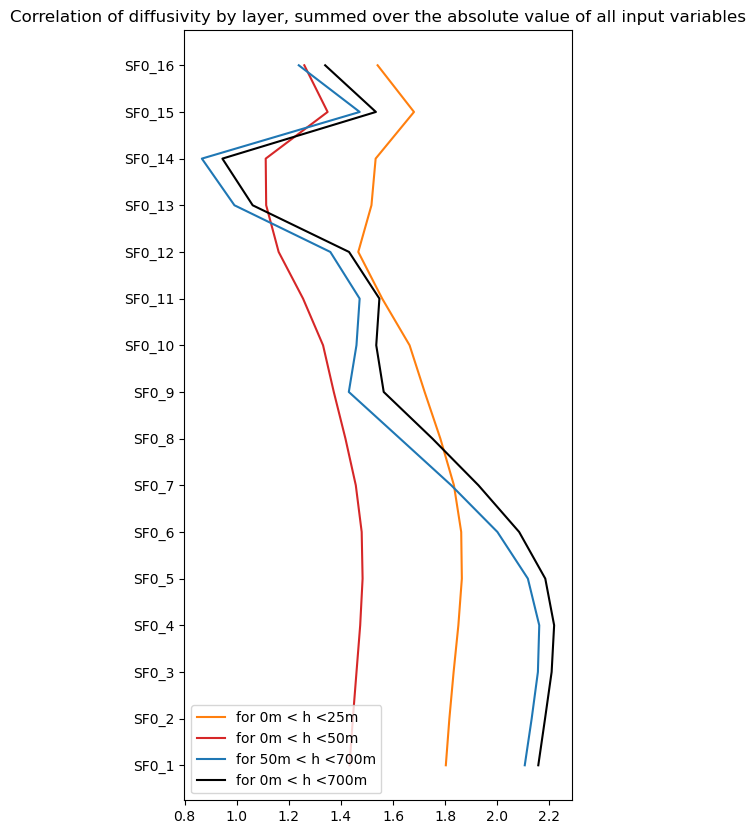

In [9]:
plt.figure(figsize=(5,10))
plt.plot(correlation_0_25_sum, y, label=f"for {bins[0]}m < h <{bins[1]}m", color='tab:orange')
plt.plot(correlation_0_50_sum, y, label=f"for {bins[0]}m < h <{bins[2]}m", color='tab:red')
plt.plot(correlation_50_700_sum, y, label=f"for {bins[2]}m < h <{bins[3]}m", color='tab:blue')
plt.plot(correlation_0_700_sum, y, label=f"for {bins[0]}m < h <{bins[3]}m", color='k')
#plt.gca().invert_yaxis()
plt.legend()
plt.yticks(ticks=np.arange(1,17,1),labels=['SF0_1','SF0_2','SF0_3','SF0_4','SF0_5','SF0_6','SF0_7','SF0_8','SF0_9','SF0_10','SF0_11','SF0_12','SF0_13','SF0_14','SF0_15','SF0_16']);
plt.title('Correlation of diffusivity by layer, summed over the absolute value of all input variables');

This plot shows the absolute value of correlation summed across all 4 inputs for each point of the shape function for four different boundary layer depth regimes:
- 0 < h < 25: very shallow boundary layers (this would indicate high stratification, likely in summer)
- 0 < h < 50: shallow boundary layers
- 50 < h < 700: deep boundary layers (this would indicate weak stratification, likely in winter)
- 0 < h < 700: entire dataset, no sorting by boundary layer depth

This plot indicates that the highest correlation at the surface (point 16) is for very shallow boundary layers, those less than 25m. This relates to the paper's finding that shallow boundary layers had lower bias. Interesting though, there is not a significant differnce between all shallow boundary layers (0<h<25) compared to deep boundary layers (50<h<700) in the upper points of the profile. This could suggest that high correlation is specific to a very small group of the shallowest mixed layers. Contrastingly, at the base of the profile (deeper in the ocean, at point 1) deep mixed layers have the highest correlation. 

# Part 2: Model Improvement

[CL] work on step-by-step model architecture

[BH] work on XGBoost model? (if it seems like it's training)

## Data Filtering (from 2.3 in the starter notebook)
To ensure high-quality and valid data for training, specific filtering criteria are applied by Sane et al. (2023):

1. Heat flux ($ \text{heat} $) magnitude below 601 $ W/m^2 $.
2. Wind stress ($ \text{tx} $) below 1.2 $ N/m^2 $.
3. Boundary layer depth ($ \text{h} $) between 30 m and 300 m.

In [4]:
# Apply the constraints defined above
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]
# Filter the data to only those that obey the constraints
# ind7 is the final filter to indentify the data that will be input to N1 training
ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6) 

In [5]:
# there are 16 levels (1 at bottom, 16 at top)
mm1=0; mm2=16  #0; 16
# apply ind7 to keep only the profiles that meet the filtering criteria
# Training uses only 4 inputs: Coriolis parameter (l0), buoyancy flux (b00), surface friction velocity (ustar0) and boundary layer depth (h0)
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff.preprocess_train_data(data_load3)  
# Note: ff.preprocess_train_data is a custom function defined in lib/func_file.py that normalizes, log-transforms and shuffles the dataset


started


## Validation Dataset (from 2.4 of the starter notebook)

In this project, training and validation datasets are generated independently through separate simulations. This practice ensures **strict independence** between the two datasets, avoiding issues like **data leakage** or overfitting. 

In [6]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header = None)  
valid_data = df.iloc[:, 3:].values 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

In [7]:
x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

## Original neural network, model training, evaluation and visualization(from section 3 to section 5 of the starter notebook)

In [8]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)  # First layer: Input to hidden
        self.linear2 = nn.Linear(Hid, Hid)       # Second layer: Hidden to hidden
        self.linear3 = nn.Linear(Hid, Out_nodes) # Third layer: Hidden to output
        self.dropout = nn.Dropout(0.25)          # Dropout for regularization

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)            # ReLU activation for layer 1
        h1 = self.dropout(h1)          # Apply dropout
        
        h2 = self.linear2(h1)
        h3 = torch.relu(h2)            # ReLU activation for layer 2
        h3 = self.dropout(h3)          # Apply dropout

        y_pred = self.linear3(h3)      # Final output layer
        return y_pred


In [9]:
def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr)  # Adam optimizer
    loss_fn = torch.nn.L1Loss(reduction='mean')  # L1 loss for gradient computation
    loss_array = torch.zeros([epochs, 3])  # Array to store epoch, train, and validation losses

    best_loss = float('inf')  # Initialize the best validation loss as infinity
    no_improvement = 0  # Counter for epochs without improvement
    best_model_state = None  # Placeholder for the best model state

    # Add a progress bar
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()  # Clear gradients from the previous step
            y_pred = model(x)  # Forward pass for training data
            
            valid_pred = model(valid_x)  # Forward pass for validation data
            
            # Loss used for gradient calculation
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)
            
            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))
            
            loss.backward()  # Backpropagate the gradient
            optimizer.step()  # Update model parameters

            # Record the losses for this epoch
            loss_array[k, 0] = k  
            loss_array[k, 1] = loss_train.item()  
            loss_array[k, 2] = loss_valid.item()  

            # Update the progress bar with the current epoch and losses
            pbar.set_postfix(
                train_loss=loss_train.item(), 
                valid_loss=loss_valid.item(), 
                patience_count=no_improvement
            )
            pbar.update(1)  # Increment the progress bar

            # Early stopping: Check if validation loss improves
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()  # Update best loss
                no_improvement = 0
                best_model_state = model.state_dict()  
            else:
                no_improvement += 1  # Increment no improvement counter

            # If no improvement for 'patience' epochs, stop training
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            # Free memory by deleting intermediate variables
            del loss, y_pred
            
    # Restore the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, loss_array[:k, :]


In [10]:
# Loss weighting option here, all weights = 1.0 in default run 
# Weight settings here
kms1=1.0 
kms2=1.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms1; k12 = kms1; k11 = kms1; 
k10 = kms1; k9 = kms1; k8 = kms1; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

In [11]:
# Train N1 for the first time!
epochs, k_points, lr=3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

### in this version, there is no weighting in the loss function. This will be added in section 6. 

Training Progress:  26%|██▌       | 767/3000 [00:26<01:15, 29.45epoch/s, patience_count=19, train_loss=0.0387, valid_loss=0.0557]


Early stopping at epoch 767. Validation loss has not improved for 20 epochs.


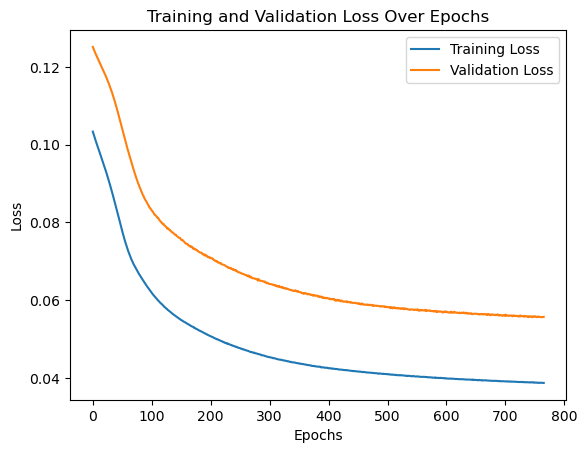

In [12]:
plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss")
plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss")

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


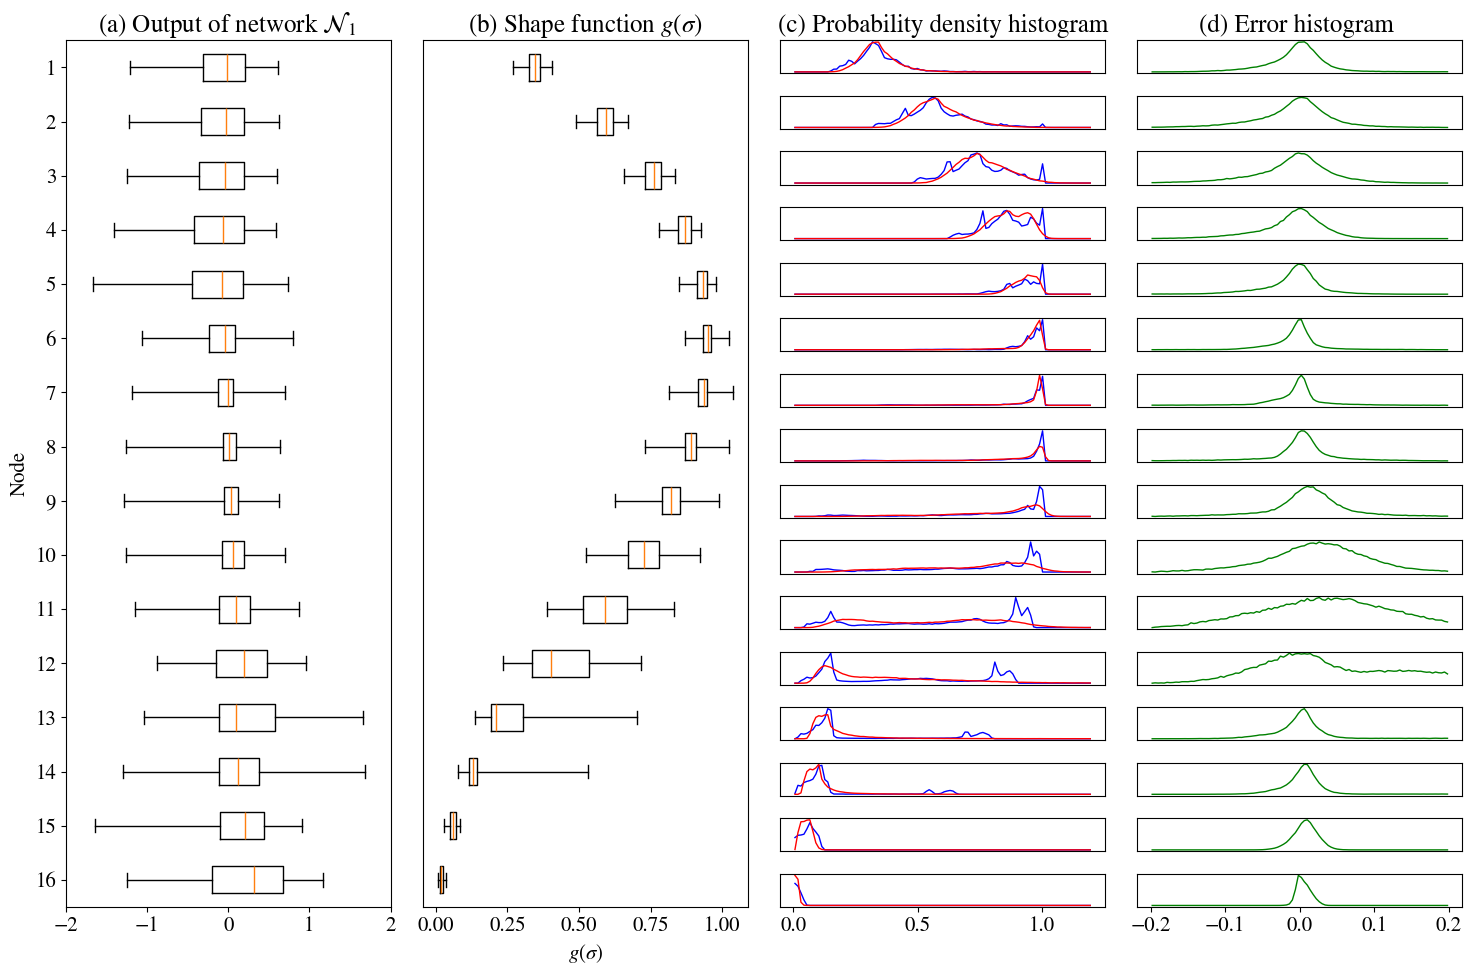

In [13]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

# Macro-Level + Refinement Model
To improve on the original neural network, we use a two-step approach in the following architecture:
1) MacroNet: Predict 4 “macro-level” outputs that each represent the average
   log-diffusivity over a subset of the vertical levels (e.g. top 4, next 4, etc.).
2) RefineNet: Concatenate the 4 macro-level predictions with the original 4 inputs
   to produce the final 16-level shape function in log-space.

This approach helps the model first capture coarse structure before
refining it into the full 16-level detail.

In [14]:
def create_macro_targets(y_16, group_size=4):
    N, L = y_16.shape
    assert L % group_size == 0, "16 must be divisible by group_size=4"
    n_groups = L // group_size
    y_reshaped = y_16.view(N, n_groups, group_size)  # shape: [N,4,4]
    y_macro = torch.mean(y_reshaped, dim=2)          # shape: [N,4]
    return y_macro
y_macro = create_macro_targets(y)
valid_y_macro = create_macro_targets(valid_y)

## MacroNet:
- Input: 4 physical features (l0, b0, ustar0, h0) 
- Two hidden layers (32 nodes each by default), ReLU + Dropout(0.25)
- Output: 4 macro-level log-diffusivities

In [15]:
class MacroNet(nn.Module):
    def __init__(self, in_nodes=4, hid=32, out_nodes=4):
        super(MacroNet, self).__init__()
        self.linear1 = nn.Linear(in_nodes, hid)
        self.linear2 = nn.Linear(hid, hid)
        self.linear3 = nn.Linear(hid, out_nodes)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        h = torch.relu(self.linear1(x))
        h = self.dropout(h)
        h = torch.relu(self.linear2(h))
        h = self.dropout(h)
        out = self.linear3(h)  # shape [batch, 4]
        return out

RefineNet:
----------
- Input: 8 features (4 original + 4 macro-level outputs)
- Two hidden layers (64 nodes each by default), ReLU + Dropout(0.25)
- Output: 16 final log-diffusivity values (one per vertical level)

In [16]:
class RefineNet(nn.Module):
    def __init__(self, in_nodes=8, hid=64, out_nodes=16):
        super(RefineNet, self).__init__()
        self.linear1 = nn.Linear(in_nodes, hid)
        self.linear2 = nn.Linear(hid, hid)
        self.linear3 = nn.Linear(hid, out_nodes)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        h = torch.relu(self.linear1(x))
        h = self.dropout(h)
        h = torch.relu(self.linear2(h))
        h = self.dropout(h)
        out = self.linear3(h)  # shape [batch, 16]
        return out

## Training Loop for MacroNet
Below is the training function for MacroNet. We measure L1 loss in log-space 
for gradient calculation, but also track real-space error by expanding the 4 macro 
outputs back to 16 levels. Early stopping is triggered when conditions are met. 

In [17]:
def train_macro_net(model, 
                    x_train, y_macro_train, 
                    x_valid, y_macro_valid, 
                    k_mean, k_std,    # shape [16], from your pipeline
                    lr=1e-3, 
                    epochs=2000, 
                    patience=20):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss()
    
    best_val_loss = float('inf')
    best_model_state = None
    no_improve = 0

    # This function expands the 4 macro preds to 16 by simply repeating each group of 4.
    def expand_macro_to_16(y_macro):
        bsz = y_macro.shape[0]
        expanded = y_macro.unsqueeze(2).expand(bsz, 4, 4).reshape(bsz, 16)
        return expanded

    # For tracking losses over epochs
    loss_array = torch.zeros((epochs, 3))

    with tqdm(total=epochs, desc="Training MacroNet", unit="epoch") as pbar:
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            # Forward pass
            y_macro_pred = model(x_train)

            # L1 in log-space (gradient calculation)
            loss_log = loss_fn(y_macro_pred, y_macro_train)

            # Also compute real-space error (just for monitoring)
            y_macro_pred_16 = expand_macro_to_16(y_macro_pred)
            y_macro_true_16 = expand_macro_to_16(y_macro_train)
            real_pred = torch.exp(y_macro_pred_16 * k_std.to(x_train.device) 
                                  + k_mean.to(x_train.device))
            real_true = torch.exp(y_macro_true_16 * k_std.to(x_train.device) 
                                  + k_mean.to(x_train.device))
            train_loss_real = torch.mean(torch.abs(real_pred - real_true))

            loss_log.backward()
            optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                y_macro_valid_pred = model(x_valid)
                loss_log_valid = loss_fn(y_macro_valid_pred, y_macro_valid)

                # Expand for real-space validation
                y_macro_valid_pred_16 = expand_macro_to_16(y_macro_valid_pred)
                y_macro_valid_true_16 = expand_macro_to_16(y_macro_valid)
                real_vpred = torch.exp(y_macro_valid_pred_16 * k_std.to(x_valid.device) 
                                       + k_mean.to(x_valid.device))
                real_vtrue = torch.exp(y_macro_valid_true_16 * k_std.to(x_valid.device) 
                                       + k_mean.to(x_valid.device))
                valid_loss_real = torch.mean(torch.abs(real_vpred - real_vtrue))

            # Record
            loss_array[epoch, 0] = epoch
            loss_array[epoch, 1] = train_loss_real.item()
            loss_array[epoch, 2] = valid_loss_real.item()

            # TQDM bar update
            pbar.set_postfix({
                "train_loss": f"{train_loss_real.item():.5f}",
                "valid_loss": f"{valid_loss_real.item():.5f}",
                "no_improve": no_improve
            })
            pbar.update(1)

            # Early stopping check
            if valid_loss_real.item() < best_val_loss:
                best_val_loss = valid_loss_real.item()
                best_model_state = copy.deepcopy(model.state_dict())
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    # Restore best
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Trim the unused epochs in loss_array if early stopped
    final_epoch = epoch if no_improve < patience else epoch - patience
    return model, loss_array[:epoch+1, :]


## Training Loop for RefineNet
Once MacroNet is trained, we produce macro-level outputs for the training 
and validation sets, concatenate them with the original 4 inputs => 8 total features,
and train RefineNet to produce the final 16-level log-diffusivity.

In [18]:
def train_refine_net(model,
                     macro_model,
                     x_train, y_train, 
                     x_valid, y_valid,
                     k_mean, k_std,
                     lr=1e-3,
                     epochs=2000,
                     patience=20):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss()

    best_val_loss = float('inf')
    best_model_state = None
    no_improve = 0
    
    # We'll record epoch, train_loss, valid_loss
    loss_array = torch.zeros((epochs, 3))

    # Precompute macro predictions
    macro_model.eval()
    with torch.no_grad():
        macro_train_pred = macro_model(x_train)  # shape [N,4]
        macro_valid_pred = macro_model(x_valid)  # shape [N_val,4]

    # Concat
    x_refine_train = torch.cat([x_train, macro_train_pred], dim=1)
    x_refine_valid = torch.cat([x_valid, macro_valid_pred], dim=1)

    with tqdm(total=epochs, desc="Training RefineNet", unit="epoch") as pbar:
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            y_pred_16 = model(x_refine_train)
            # L1 in log-space
            loss_log = loss_fn(y_pred_16, y_train)

            # Real-space for training
            real_pred = torch.exp(y_pred_16 * k_std.to(x_train.device) 
                                  + k_mean.to(x_train.device))
            real_true = torch.exp(y_train * k_std.to(x_train.device) 
                                  + k_mean.to(x_train.device))
            train_loss_real = torch.mean(torch.abs(real_pred - real_true))

            loss_log.backward()
            optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                y_vpred_16 = model(x_refine_valid)
                loss_log_valid = loss_fn(y_vpred_16, y_valid)
                real_vpred = torch.exp(y_vpred_16 * k_std.to(x_valid.device) 
                                       + k_mean.to(x_valid.device))
                real_vtrue = torch.exp(y_valid * k_std.to(x_valid.device) 
                                       + k_mean.to(x_valid.device))
                valid_loss_real = torch.mean(torch.abs(real_vpred - real_vtrue))

            # Record
            loss_array[epoch, 0] = epoch
            loss_array[epoch, 1] = train_loss_real.item()
            loss_array[epoch, 2] = valid_loss_real.item()

            pbar.set_postfix({
                "train_loss": f"{train_loss_real.item():.5f}",
                "valid_loss": f"{valid_loss_real.item():.5f}",
                "no_improve": no_improve
            })
            pbar.update(1)

            # Early stopping
            if valid_loss_real.item() < best_val_loss:
                best_val_loss = valid_loss_real.item()
                best_model_state = copy.deepcopy(model.state_dict())
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"Refine Early stopping at epoch {epoch}")
                    break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, loss_array[:epoch+1, :]

## Hyperparameter Sweep for Macro+Refine
Similar to starter notebook section 6.2, we do a simple hyperparameter sweep where we vary:
- MacroNet hidden size from [16,32]
- RefineNet hidden size from [32,64]
For each pair, we train both networks (with fewer epochs for speed) and record the final validation loss.

In [19]:
macro_hidden_options = [16, 32]
refine_hidden_options = [32, 64]

best_config = None
best_val_loss = float('inf')
# Due to time constraint, we skip hyperparameter sweep. Uncomment the next cell block if wish to do hyperparameter sweep. 

In [20]:
# for mh in macro_hidden_options:
#     for rh in refine_hidden_options:
#         print(f"=== Testing Macro hidden={mh}, Refine hidden={rh} ===")
        
#         # 1) Build macro net
#         macro_model = MacroNet(in_nodes=4, hid=mh, out_nodes=4).to(device)
#         macro_model, macro_loss_arr = train_macro_net(
#             macro_model,
#             x, y_macro,
#             valid_x, valid_y_macro,
#             k_mean_c, k_std_c,
#             lr=1e-3,
#             epochs=2000,     # change this if necessary
#             patience=10
#         )
        
#         # 2) Build refine net
#         refine_model = RefineNet(in_nodes=8, hid=rh, out_nodes=16).to(device)
#         refine_model, refine_loss_arr = train_refine_net(
#             refine_model,
#             macro_model,
#             x, y,
#             valid_x, valid_y,
#             k_mean_c, k_std_c,
#             lr=1e-3,
#             epochs=2000,
#             patience=10
#         )
        
#         # measure final valid loss from refine_loss_arr
#         final_val_loss = refine_loss_arr[-1,2]
        
#         print(f"Macro hidden={mh}, Refine hidden={rh}, final Val Loss={final_val_loss:.5f}")
        
#         # keep track
#         if final_val_loss < best_val_loss:
#             best_val_loss = final_val_loss
#             best_config = (mh, rh)

# print(f"\nBest config is Macro hidden={best_config[0]}, Refine hidden={best_config[1]} with val_loss={best_val_loss:.5f}")

In [21]:
if best_config:
    mh, rh = best_config[0], best_config[1]
else:
    mh, rh = 32, 64 # obtained from previous hyperparameter tuning
print(f"\nUsing the best config with Macro hidden={mh}, Refine hidden={rh}")

macro_model = MacroNet(in_nodes=4, hid=mh, out_nodes=4).to(device)
macro_model, macro_loss_arr = train_macro_net(
    macro_model,
    x, y_macro,
    valid_x, valid_y_macro,
    k_mean_c, k_std_c,
    lr=1e-3,
    epochs=2000,
    patience=10
)

refine_model = RefineNet(in_nodes=8, hid=rh, out_nodes=16).to(device)
refine_model, refine_loss_arr = train_refine_net(
    refine_model,
    macro_model,
    x, y,
    valid_x, valid_y,
    k_mean_c, k_std_c,
    lr=1e-3,
    epochs=2000,
    patience=10
)

final_val_loss = refine_loss_arr[-1,2]

print(f"final Val Loss={final_val_loss:.5f}")


Using the best config with Macro hidden=32, Refine hidden=64


Training MacroNet:  38%|███▊      | 762/2000 [00:22<00:37, 33.30epoch/s, train_loss=0.03691, valid_loss=0.04521, no_improve=9]


Early stopping at epoch 761


Training RefineNet:  42%|████▏     | 839/2000 [00:45<01:03, 18.28epoch/s, train_loss=0.02892, valid_loss=0.03853, no_improve=9]

Refine Early stopping at epoch 838
final Val Loss=0.03853


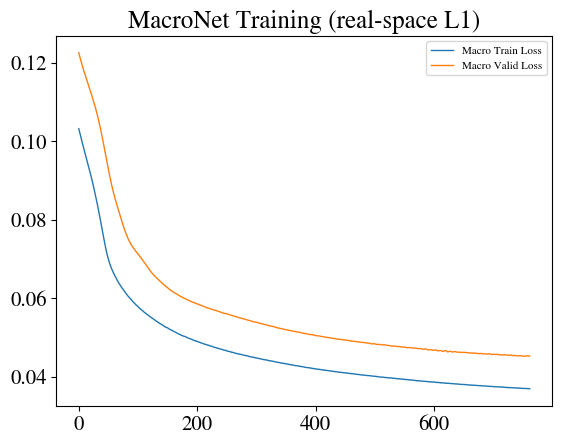

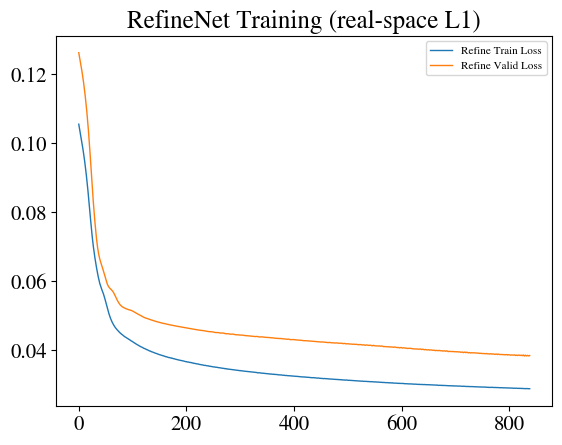

In [22]:
# Plot train/val loss curves for each stage for the best config
plt.figure()
plt.plot(macro_loss_arr[:,0], macro_loss_arr[:,1], label='Macro Train Loss')
plt.plot(macro_loss_arr[:,0], macro_loss_arr[:,2], label='Macro Valid Loss')
plt.legend()
plt.title("MacroNet Training (real-space L1)")

plt.figure()
plt.plot(refine_loss_arr[:,0], refine_loss_arr[:,1], label='Refine Train Loss')
plt.plot(refine_loss_arr[:,0], refine_loss_arr[:,2], label='Refine Valid Loss')
plt.legend()
plt.title("RefineNet Training (real-space L1)")
plt.show()

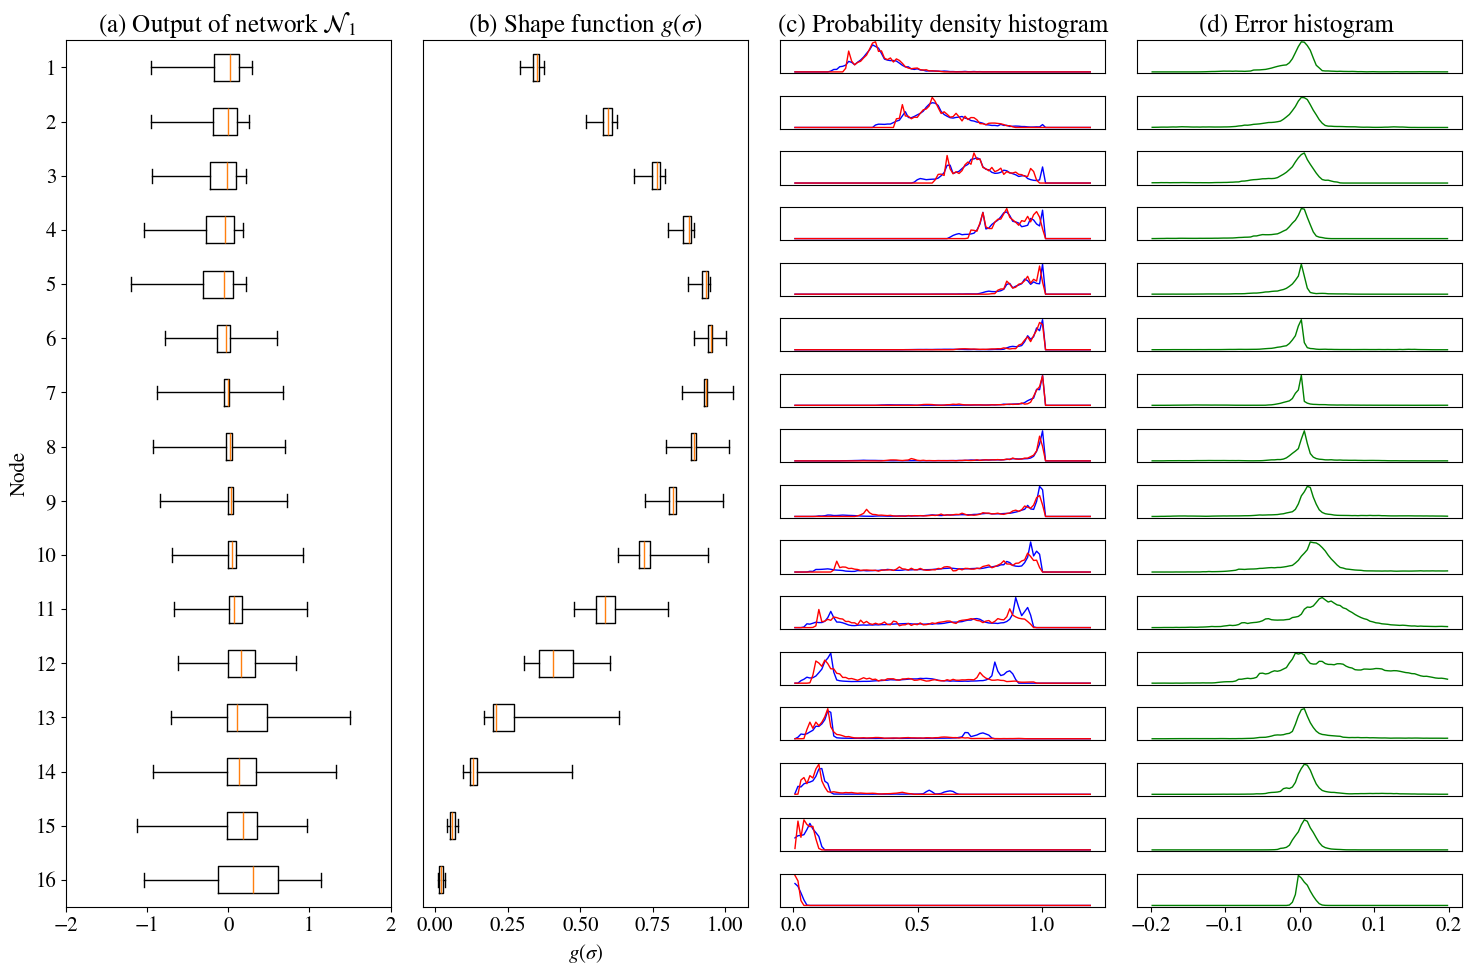

In [23]:
class MacroRefineWrapper(nn.Module):
    def __init__(self, macro_model, refine_model):
        super(MacroRefineWrapper, self).__init__()
        self.macro_model = macro_model
        self.refine_model = refine_model
    
    def forward(self, x):
        with torch.no_grad():
            macro_pred = self.macro_model(x)
            x_plus = torch.cat([x, macro_pred], dim=1)
            y_out = self.refine_model(x_plus)
        return y_out

macro_refine_wrapper = MacroRefineWrapper(macro_model, refine_model)
performance_sigma_point(macro_refine_wrapper, x, valid_x, y, valid_y, k_mean, k_std)

# ParamShapeModel:
We produce a small, learnable set of 'coarse shape' parameters from the 4 input features,
then concatenate them with the original features to output the full 16-level
log-diffusivity. This entire process is learned end-to-end using the final 16-level 
targets in log-space. We track training and validation L1 error (in real space)
and use early stopping. Below, we also add a simple hyperparameter search example.

In [24]:
class ParamShapeModel(nn.Module):
    def __init__(self, in_nodes=4, param_count=4, 
                 hid_coarse=32, hid_refine=64, out_nodes=16):
        super(ParamShapeModel, self).__init__()
        
        # Coarse net
        self.coarse_linear1 = nn.Linear(in_nodes, hid_coarse)
        self.coarse_linear2 = nn.Linear(hid_coarse, hid_coarse)
        self.coarse_linear3 = nn.Linear(hid_coarse, param_count)
        self.coarse_dropout = nn.Dropout(0.25)
        
        # Refine net
        refine_in = in_nodes + param_count
        self.refine_linear1 = nn.Linear(refine_in, hid_refine)
        self.refine_linear2 = nn.Linear(hid_refine, hid_refine)
        self.refine_linear3 = nn.Linear(hid_refine, out_nodes)
        self.refine_dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Coarse shape
        h = torch.relu(self.coarse_linear1(x))
        h = self.coarse_dropout(h)
        h = torch.relu(self.coarse_linear2(h))
        h = self.coarse_dropout(h)
        coarse_out = self.coarse_linear3(h)  # shape [batch, param_count]
        
        # Refine to 16 levels
        x_plus = torch.cat([x, coarse_out], dim=1)
        r = torch.relu(self.refine_linear1(x_plus))
        r = self.refine_dropout(r)
        r = torch.relu(self.refine_linear2(r))
        r = self.refine_dropout(r)
        final_out = self.refine_linear3(r)  # shape [batch,16]
        return final_out

## Training ParamShapeModel
We use a single end-to-end training function. 

In [25]:
def train_param_shape_model(model, 
                            x_train, y_train, 
                            x_valid, y_valid,
                            k_mean, k_std,
                            lr=1e-3, 
                            epochs=3000,
                            patience=20):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss(reduction='mean')  
    loss_array = torch.zeros((epochs, 3))
    
    best_loss = float('inf')
    no_improvement = 0
    best_model_state = None

    with tqdm(total=epochs, desc="Training ParamShapeModel", unit="epoch") as pbar:
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            # forward pass
            y_pred = model(x_train)   # shape [N,16], log-space
            # compute L1 in log-space
            loss_log = loss_fn(y_pred, y_train)

            # compute real-space L1 for training (monitor only)
            real_pred = torch.exp(y_pred * k_std.to(x_train.device) + k_mean.to(x_train.device))
            real_true = torch.exp(y_train * k_std.to(x_train.device) + k_mean.to(x_train.device))
            train_loss_real = torch.mean(torch.abs(real_pred - real_true))

            loss_log.backward()
            optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                y_pred_valid = model(x_valid)
                loss_log_valid = loss_fn(y_pred_valid, y_valid)
                real_pred_v = torch.exp(y_pred_valid * k_std.to(x_valid.device) 
                                        + k_mean.to(x_valid.device))
                real_true_v = torch.exp(y_valid * k_std.to(x_valid.device) 
                                        + k_mean.to(x_valid.device))
                valid_loss_real = torch.mean(torch.abs(real_pred_v - real_true_v))

            # record
            loss_array[epoch, 0] = epoch
            loss_array[epoch, 1] = train_loss_real.item()
            loss_array[epoch, 2] = valid_loss_real.item()

            pbar.set_postfix({
                "train_loss": f"{train_loss_real.item():.5f}",
                "valid_loss": f"{valid_loss_real.item():.5f}",
                "no_improve": no_improvement
            })
            pbar.update(1)

            # early stopping
            if valid_loss_real.item() < best_loss:
                best_loss = valid_loss_real.item()
                best_model_state = copy.deepcopy(model.state_dict())
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement >= patience:
                    print(f"Stopping early at epoch {epoch}")
                    break

    # restore best
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, loss_array[:epoch+1, :]

## Hyperparameter Sweep for ParamShapeModel
We vary:
- param_count: number of coarse shape parameters
- hid_coarse, hid_refine: hidden sizes for coarse net and refine net

In [26]:
param_count_list = [2, 4]
hid_coarse_list = [16, 32]
hid_refine_list = [32, 64]

best_config_ps = None
best_loss_ps = float('inf')
# Due to time constraint, we skip hyperparameter sweep. Uncomment the next cell block if wish to do hyperparameter sweep.

In [27]:
# for pc in param_count_list:
#     for hc in hid_coarse_list:
#         for hr in hid_refine_list:
#             print(f"\n-- ParamShape: pCount={pc}, hid_coarse={hc}, hid_refine={hr} --")
#             param_model = ParamShapeModel(
#                 in_nodes=4,
#                 param_count=pc,
#                 hid_coarse=hc,
#                 hid_refine=hr,
#                 out_nodes=16
#             ).to(device)

#             param_model, param_loss_arr = train_param_shape_model(
#                 param_model,
#                 x, y,
#                 valid_x, valid_y,
#                 k_mean_c, k_std_c,
#                 lr=1e-3,
#                 epochs=2000,
#                 patience=10
#             )
#             final_val_loss = param_loss_arr[-1,2]
#             print(f"Final Val Loss = {final_val_loss:.5f}")
            
#             if final_val_loss < best_loss_ps:
#                 best_loss_ps = final_val_loss
#                 best_config_ps = (pc, hc, hr)

# print(f"\nBest config: param_count={best_config_ps[0]}, hid_coarse={best_config_ps[1]}, hid_refine={best_config_ps[2]}, val_loss={best_loss_ps:.5f}")

In [28]:
if best_config_ps:
    pc, hc, hr = best_config_ps[0], best_config_ps[1], best_config_ps[2]
else:
    pc, hc, hr = 4, 32, 64
print(f"\nUsing best config with param_count={pc}, hid_coarse={hc}, hid_refine={hr}")
param_model = ParamShapeModel(
    in_nodes=4,
    param_count=pc,
    hid_coarse=hc,
    hid_refine=hr,
    out_nodes=16
).to(device)

param_model, param_loss_arr = train_param_shape_model(
    param_model,
    x, y,
    valid_x, valid_y,
    k_mean_c, k_std_c,
    lr=1e-3,
    epochs=2000,
    patience=10
)
final_val_loss = param_loss_arr[-1,2]
print(f"final val loss = {final_val_loss:.5f}")


Using best config with param_count=4, hid_coarse=32, hid_refine=64


Training ParamShapeModel:  25%|██▌       | 504/2000 [00:40<02:00, 12.39epoch/s, train_loss=0.03195, valid_loss=0.03908, no_improve=9]

Stopping early at epoch 503
final val loss = 0.03908


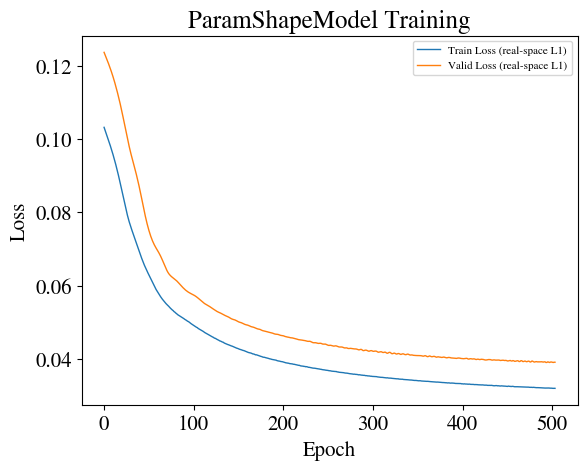

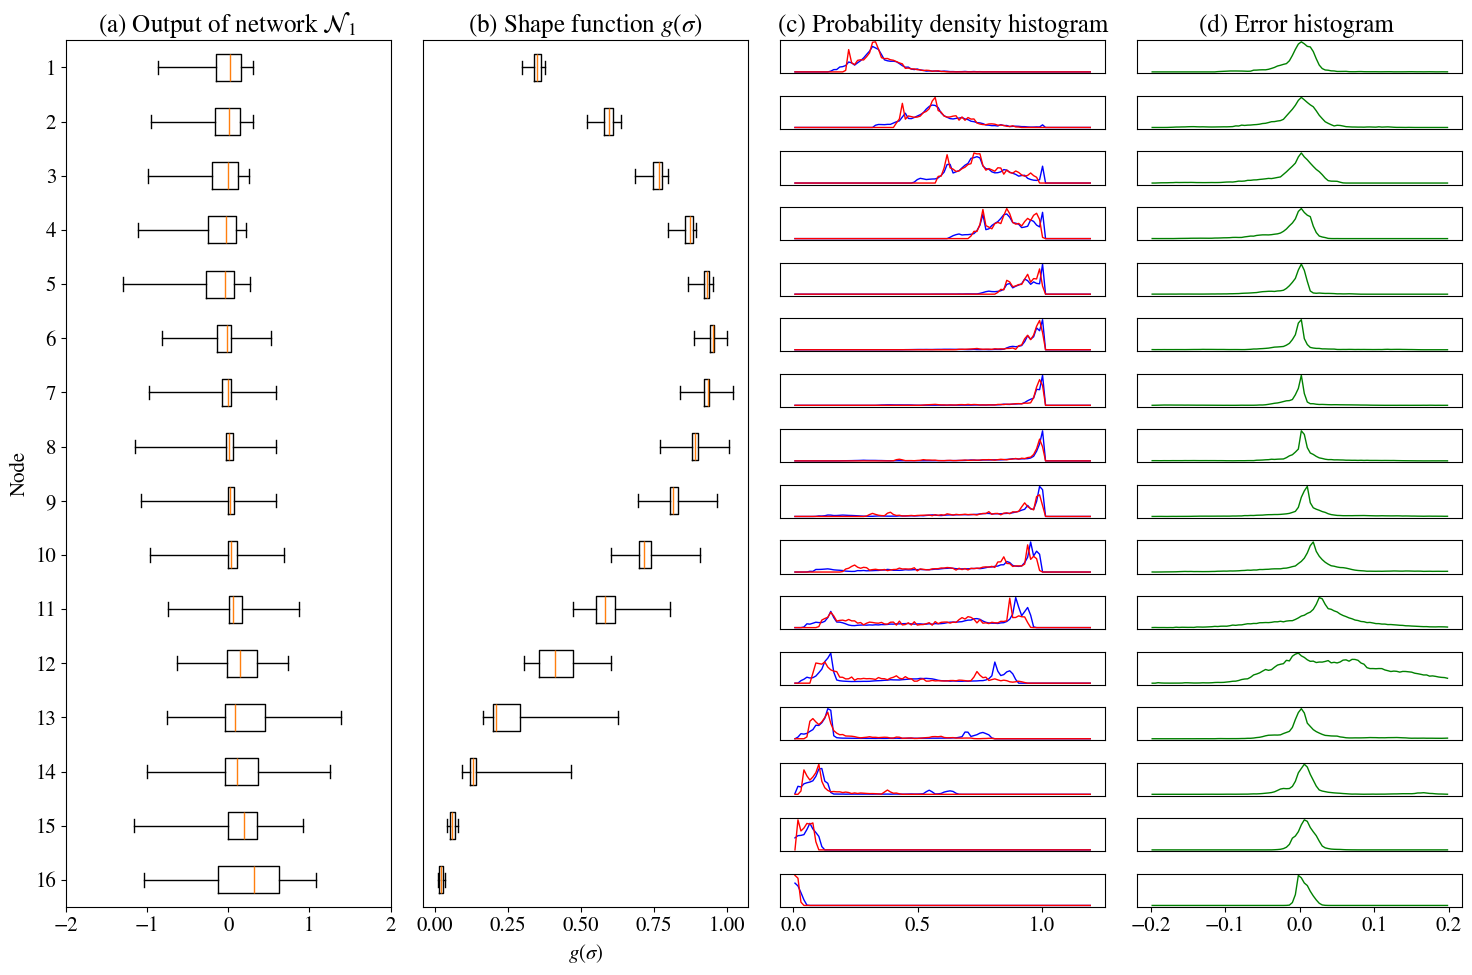

In [29]:
# Plot the train/val loss
plt.figure()
plt.plot(param_loss_arr[:,0], param_loss_arr[:,1], label="Train Loss (real-space L1)")
plt.plot(param_loss_arr[:,0], param_loss_arr[:,2], label="Valid Loss (real-space L1)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ParamShapeModel Training")
plt.legend()
plt.show()

# Evaluate final predictions
performance_sigma_point(
    param_model, 
    x, valid_x, 
    y, valid_y, 
    k_mean, k_std
)

# Results Comparison
Now we get MAEs for each of the 16 nodes of the three models, and plot the comparison of MAE each node, as well as correlation each node, for the three models. 

In [30]:
def get_predictions_16(model_type,
                       x_in,           # shape [N,4]
                       macro_model=None,
                       refine_model=None,
                       param_shape_model=None,
                       k_mean=None,
                       k_std=None):
    """
    Returns the predicted shape function in *real space* [N,16].
    model_type: one of ["original", "macro_refine", "param_shape"].
    x_in: input data (torch.Tensor, [N,4]).
    
    For "macro_refine", pass macro_model & refine_model.
    For "param_shape", pass param_shape_model.
    For "original", pass 'model' in param_shape_model (just re-using an argument).
    
    k_mean, k_std: arrays of length 16 for exponent/log-scaling.
    """
    device_ = x_in.device
    
    with torch.no_grad():
        if model_type == "original":
            # param_shape_model is actually the "original" in this usage
            log_pred = param_shape_model(x_in)  # shape [N,16]
        
        elif model_type == "macro_refine":
            macro_pred = macro_model(x_in)                 # shape [N,4]
            x_plus = torch.cat([x_in, macro_pred], dim=1)  # shape [N,8]
            log_pred = refine_model(x_plus)                # shape [N,16]
        
        elif model_type == "param_shape":
            log_pred = param_shape_model(x_in)             # shape [N,16]
        else:
            raise ValueError(f"Unknown model_type: {model_type}")

    # convert from log space to real space
    real_pred = torch.exp(log_pred * torch.tensor(k_std).to(device_) +
                          torch.tensor(k_mean).to(device_))
    return real_pred


In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def compare_3_models(x_valid, y_valid, 
                     model_original, macro_model, refine_model, param_model,
                     k_mean, k_std):
    """
    x_valid, y_valid: shape [N,4], [N,16] in log space.
    model_original: the single-step original net
    macro_model, refine_model: for the macro+refine approach
    param_model: the ParamShape model
    k_mean, k_std: for exponent transform
    
    Prints out or plots the node-wise MAE and correlation for each approach.
    """
    # Convert y_valid to real space for comparison
    real_true = torch.exp(y_valid * torch.tensor(k_std).to(y_valid.device) +
                          torch.tensor(k_mean).to(y_valid.device))

    # Get real predictions from each approach
    real_pred_orig = get_predictions_16("original", x_valid, 
                                         param_shape_model=model_original,
                                         k_mean=k_mean, k_std=k_std)
    real_pred_macro = get_predictions_16("macro_refine", x_valid, 
                                          macro_model=macro_model,
                                          refine_model=refine_model,
                                          k_mean=k_mean, k_std=k_std)
    real_pred_param = get_predictions_16("param_shape", x_valid, 
                                          param_shape_model=param_model,
                                          k_mean=k_mean, k_std=k_std)

    # Convert to CPU numpy for analysis
    np_true = real_true.cpu().numpy()
    np_orig = real_pred_orig.cpu().numpy()
    np_macro = real_pred_macro.cpu().numpy()
    np_param = real_pred_param.cpu().numpy()

    N, L = np_true.shape
    mae_orig = []
    mae_macro = []
    mae_param = []
    corr_orig = []
    corr_macro = []
    corr_param = []

    for node_idx in range(L):
        t_node = np_true[:, node_idx]
        o_node = np_orig[:, node_idx]
        m_node = np_macro[:, node_idx]
        p_node = np_param[:, node_idx]

        # compute MAE
        mae_orig.append(np.mean(np.abs(o_node - t_node)))
        mae_macro.append(np.mean(np.abs(m_node - t_node)))
        mae_param.append(np.mean(np.abs(p_node - t_node)))

        # compute correlation
        corr_orig.append(pearsonr(o_node, t_node)[0])   # correlation coefficient
        corr_macro.append(pearsonr(m_node, t_node)[0])
        corr_param.append(pearsonr(p_node, t_node)[0])

    # Let's make a quick table in text form
    print("\n=== Node-wise MAE (real space) ===")
    print("Node | Original | MacroRefine | ParamShape")
    for i in range(L):
        print(f"{i+1:4d} | {mae_orig[i]:8.4f} | {mae_macro[i]:11.4f} | {mae_param[i]:10.4f}")

    print("\n=== Node-wise Correlation (real space) ===")
    print("Node | Original | MacroRefine | ParamShape")
    for i in range(L):
        print(f"{i+1:4d} | {corr_orig[i]:8.4f} | {corr_macro[i]:11.4f} | {corr_param[i]:10.4f}")
    
    # Plot side-by-side bars for each node, for easy visual
    nodes = np.arange(1, L+1)
    width = 0.25
    
    plt.figure(figsize=(10,5))
    plt.bar(nodes - width, mae_orig, width, label='Original')
    plt.bar(nodes, mae_macro, width, label='MacroRefine')
    plt.bar(nodes + width, mae_param, width, label='ParamShape')
    plt.xlabel("Node")
    plt.ylabel("MAE (in real space)")
    plt.title("Mean Absolute Error per Node: 3 Models")
    plt.xticks(nodes)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.bar(nodes - width, corr_orig, width, label='Original')
    plt.bar(nodes, corr_macro, width, label='MacroRefine')
    plt.bar(nodes + width, corr_param, width, label='ParamShape')
    plt.xlabel("Node")
    plt.ylabel("Pearson Correlation")
    plt.title("Correlation per Node: 3 Models")
    plt.xticks(nodes)
    plt.ylim([0,1])  # correlation range
    plt.legend()
    plt.show()



=== Node-wise MAE (real space) ===
Node | Original | MacroRefine | ParamShape
   1 |   0.0082 |      0.0074 |     0.0075
   2 |   0.0146 |      0.0117 |     0.0117
   3 |   0.0639 |      0.0517 |     0.0529
   4 |   0.1217 |      0.0869 |     0.0896
   5 |   0.1269 |      0.0847 |     0.0862
   6 |   0.1069 |      0.0710 |     0.0714
   7 |   0.0865 |      0.0606 |     0.0596
   8 |   0.0693 |      0.0499 |     0.0493
   9 |   0.0517 |      0.0371 |     0.0381
  10 |   0.0396 |      0.0268 |     0.0290
  11 |   0.0313 |      0.0202 |     0.0217
  12 |   0.0286 |      0.0176 |     0.0186
  13 |   0.0327 |      0.0203 |     0.0207
  14 |   0.0386 |      0.0239 |     0.0240
  15 |   0.0398 |      0.0252 |     0.0250
  16 |   0.0302 |      0.0196 |     0.0188

=== Node-wise Correlation (real space) ===
Node | Original | MacroRefine | ParamShape
   1 |   0.6407 |      0.7660 |     0.7678
   2 |   0.8229 |      0.8989 |     0.9061
   3 |   0.6890 |      0.8615 |     0.8683
   4 |   0.6166 |

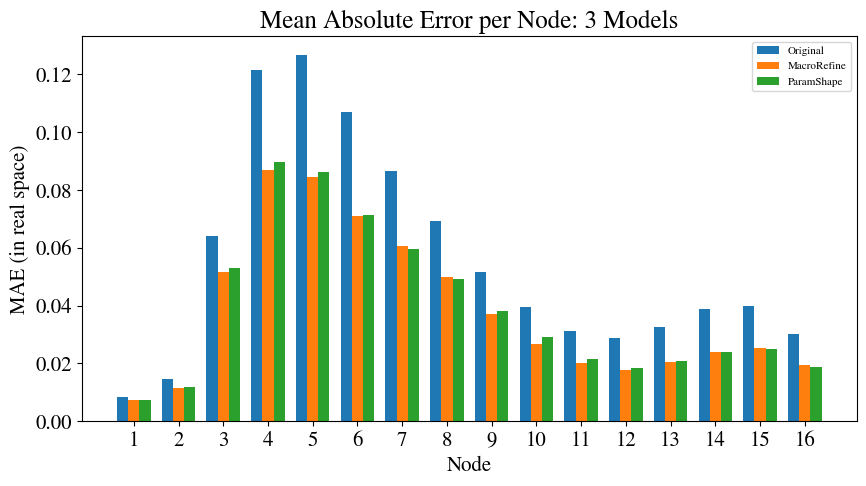

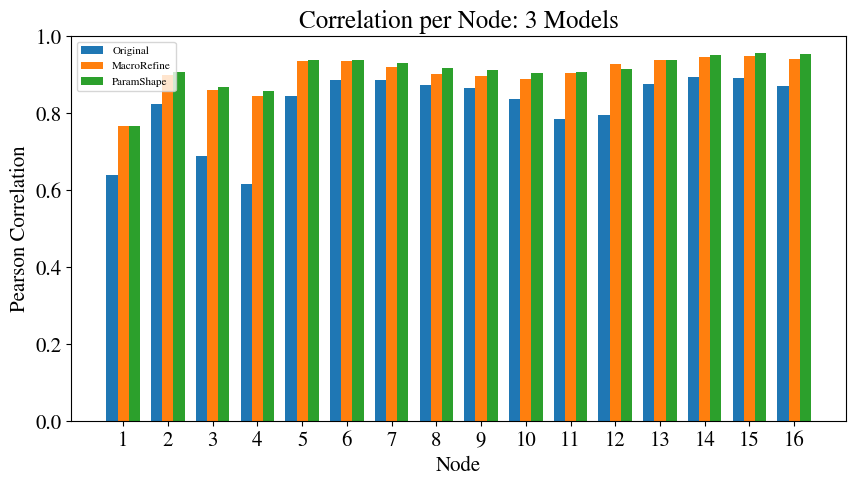

In [32]:
compare_3_models(valid_x, valid_y,
                 model,
                 macro_model, refine_model,
                 param_model,
                 k_mean, k_std)



🔁 Training NN with input combination A: ['l0', 'b0', 'ustar0', 'h0']


Training Progress:  26%|██▌       | 767/3000 [00:26<01:15, 29.47epoch/s, patience_count=19, train_loss=0.0387, valid_loss=0.0557]



Early stopping at epoch 767. Validation loss has not improved for 20 epochs.

🔁 Training NN with input combination B: ['b0', 'ustar0', 'h0']


Training Progress:  20%|██        | 615/3000 [00:20<01:21, 29.36epoch/s, patience_count=19, train_loss=0.0513, valid_loss=0.0625]



Early stopping at epoch 615. Validation loss has not improved for 20 epochs.

🔁 Training NN with input combination C: ['l0', 'ustar0', 'h0']


Training Progress:  46%|████▌     | 1367/3000 [00:46<00:55, 29.19epoch/s, patience_count=19, train_loss=0.0504, valid_loss=0.058] 



Early stopping at epoch 1367. Validation loss has not improved for 20 epochs.

🔁 Training NN with input combination D: ['l0', 'b0', 'h0']


Training Progress:  24%|██▍       | 735/3000 [00:25<01:17, 29.18epoch/s, patience_count=19, train_loss=0.0434, valid_loss=0.0632]



Early stopping at epoch 735. Validation loss has not improved for 20 epochs.

🔁 Training NN with input combination E: ['l0', 'b0', 'ustar0']


Training Progress:  31%|███       | 926/3000 [00:31<01:11, 29.11epoch/s, patience_count=19, train_loss=0.0375, valid_loss=0.0546]



Early stopping at epoch 926. Validation loss has not improved for 20 epochs.

📈 Best performing input combination: E (['l0', 'b0', 'ustar0'])
Mean R²: 0.6451


Training Progress:  31%|███       | 926/3000 [00:31<01:11, 29.05epoch/s, patience_count=19, train_loss=0.0375, valid_loss=0.0546]



Early stopping at epoch 926. Validation loss has not improved for 20 epochs.


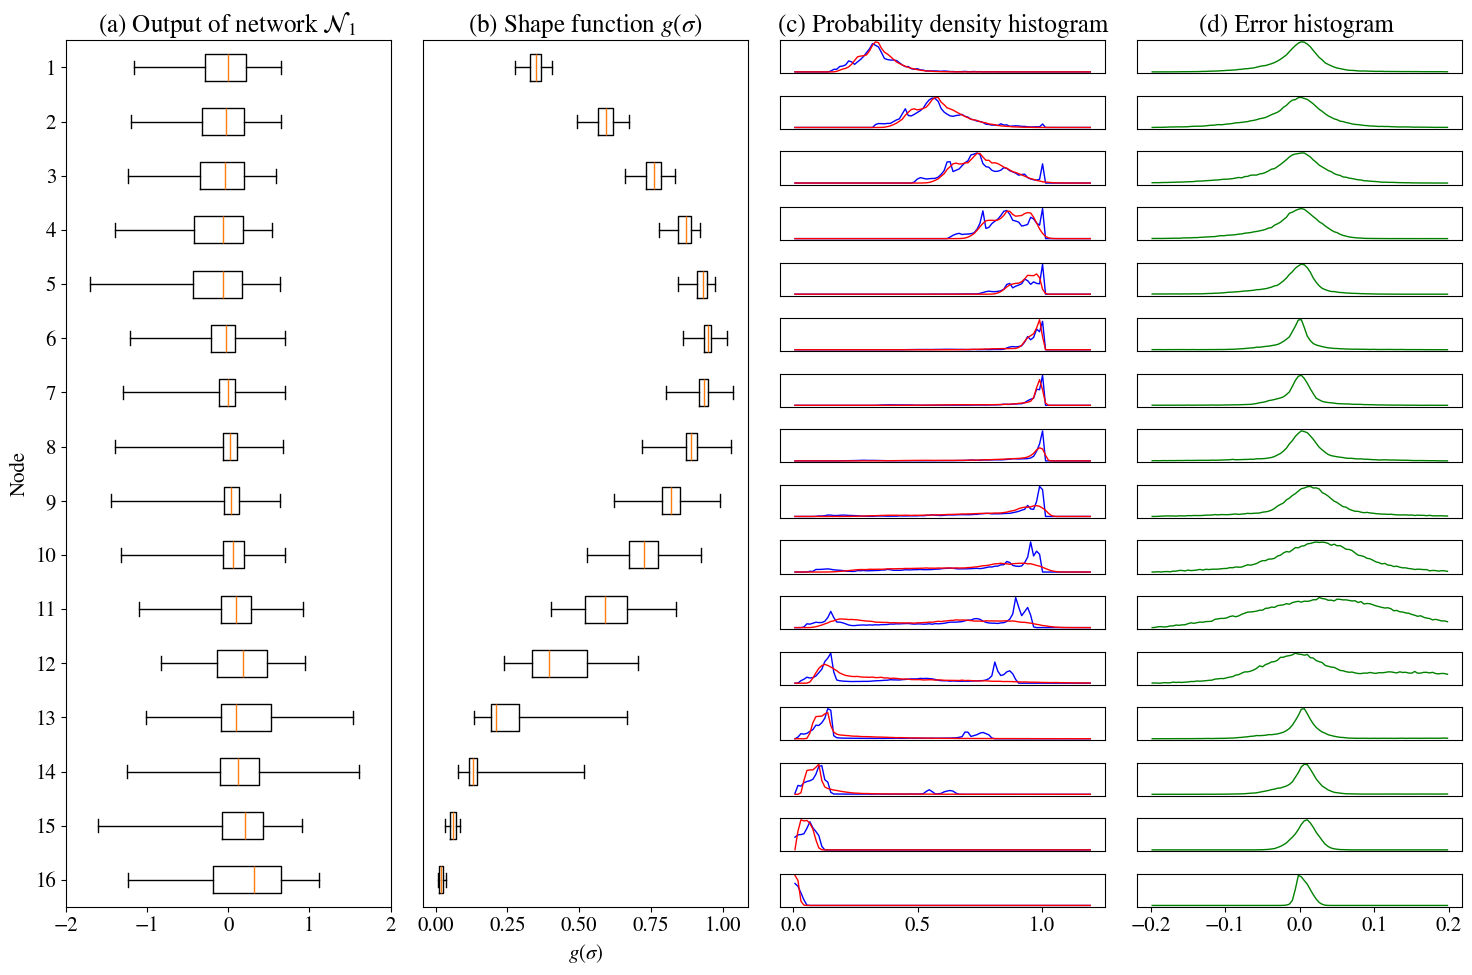

In [33]:
import torch
import numpy as np
from sklearn.metrics import r2_score

# Save original input to avoid pollution
x_original = x.clone()
y_original = y.clone()
valid_x_original = valid_x.clone()
valid_y_original = valid_y.clone()

input_combinations = {
    'A': ['l0', 'b0', 'ustar0', 'h0'],
    'B': ['b0', 'ustar0', 'h0'],
    'C': ['l0', 'ustar0', 'h0'],
    'D': ['l0', 'b0', 'h0'],
    'E': ['l0', 'b0', 'ustar0']
}

results_nn = {}

for key, vars_used in input_combinations.items():
    print(f"\n🔁 Training NN with input combination {key}: {vars_used}")

    # Build input indices
    var_idx = {
        'l0': 0,
        'b0': 1,
        'ustar0': 2,
        'h0': 3
    }
    indices = [var_idx[v] for v in vars_used]

    # Use cloned data to avoid overwriting original inputs
    x_subset = x_original[:, indices]
    valid_x_subset = valid_x_original[:, indices]

    # Neural network architecture parameters
    in_nod = len(indices)
    hid_nod = 32
    o_nod = 16
    epochs = 3000
    lr = 1e-3
    patience = 20

    # Normalization parameters
    k_mean_c = torch.tensor(k_mean).float().to(device)
    k_std_c = torch.tensor(k_std).float().to(device)
    kmask_tensor = torch.ones(16).to(device)

    torch.manual_seed(10)
    model = learnKappa_layers(in_nod, hid_nod, o_nod).to(device)

    # Train the model
    model, loss_array = modeltrain_loss(
        in_nod, hid_nod, o_nod, lr, epochs,
        x_subset, y_original,
        valid_x_subset, valid_y_original,
        model, kmask_tensor, k_mean_c, k_std_c,
        patience=patience
    )

    # Make validation predictions
    with torch.no_grad():
        pred = model(valid_x_subset)
        pred_exp = torch.exp(pred * k_std_c + k_mean_c)
        true_exp = torch.exp(valid_y_original * k_std_c + k_mean_c)

    # Calculate MAE and R² per node
    abs_error = torch.abs(pred_exp - true_exp).cpu().numpy()
    mae_per_node = np.mean(abs_error, axis=0)

    pred_np = pred_exp.cpu().numpy()
    true_np = true_exp.cpu().numpy()

    r2_per_node = [r2_score(true_np[:, i], pred_np[:, i]) for i in range(16)]

    results_nn[key] = {
        'MAE': mae_per_node,
        'R2': r2_per_node,
        'mean_MAE': np.mean(mae_per_node),
        'mean_R2': np.mean(r2_per_node)
    }

# 🔍 Find the best input combination based on mean R²
best_combo = max(results_nn.items(), key=lambda x: x[1]['mean_R2'])[0]
print(f"\n📈 Best performing input combination: {best_combo} ({input_combinations[best_combo]})")
print(f"Mean R²: {results_nn[best_combo]['mean_R2']:.4f}")

# Retrain with the best input combination for visualization
indices = [var_idx[v] for v in input_combinations[best_combo]]
x_best = x_original[:, indices]
valid_x_best = valid_x_original[:, indices]

in_nod = len(indices)
torch.manual_seed(10)
model_best = learnKappa_layers(in_nod, hid_nod, o_nod).to(device)

model_best, _ = modeltrain_loss(
    in_nod, hid_nod, o_nod, lr, epochs,
    x_best, y_original,
    valid_x_best, valid_y_original,
    model_best, kmask_tensor, k_mean_c, k_std_c,
    patience=patience
)

# ✅ Visualize performance using the best model and selected input combination
performance_sigma_point(
    model_best,
    x_best,
    valid_x_best,
    y_original,
    valid_y_original,
    k_mean,
    k_std
)


📊 NN Input Combination Performance Summary:

Combo Inputs                           Mean MAE    Mean R²
------------------------------------------------------------
A     l0, b0, ustar0, h0                 0.0557     0.6297
B     b0, ustar0, h0                     0.0623     0.5464
C     l0, ustar0, h0                     0.0578     0.6030
D     l0, b0, h0                         0.0630     0.5229
E     l0, b0, ustar0                     0.0544     0.6451


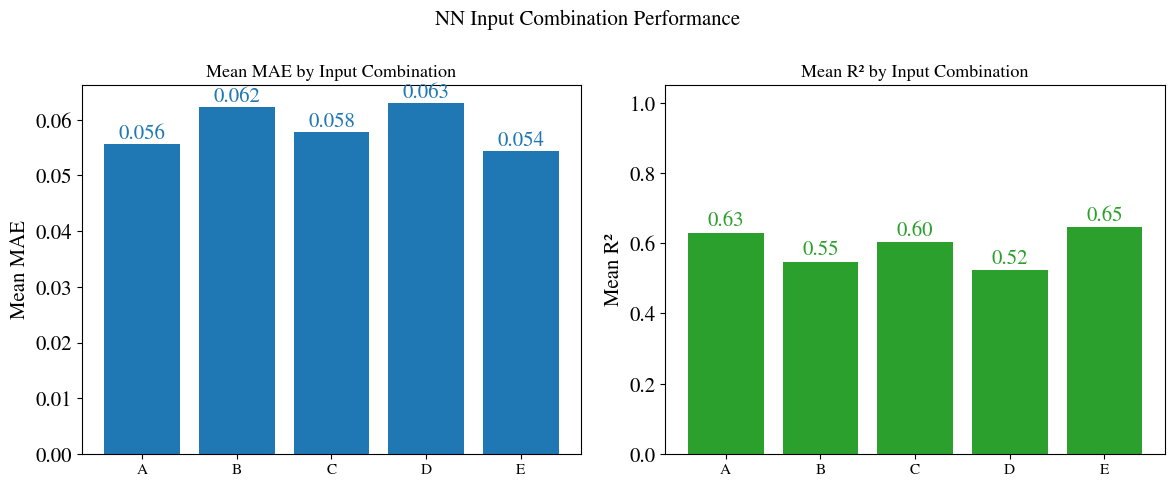

In [34]:
print("\n📊 NN Input Combination Performance Summary:\n")
print(f"{'Combo':<5} {'Inputs':<30} {'Mean MAE':>10} {'Mean R²':>10}")
print("-"*60)
for key in input_combinations:
    mae = results_nn[key]['mean_MAE']
    r2 = results_nn[key]['mean_R2']
    vars_used = ", ".join(input_combinations[key])
    print(f"{key:<5} {vars_used:<30} {mae:10.4f} {r2:10.4f}")

# Extract data
combo_keys = list(input_combinations.keys())
mae_values = [results_nn[k]['mean_MAE'] for k in combo_keys]
r2_values = [results_nn[k]['mean_R2'] for k in combo_keys]
labels = [", ".join(input_combinations[k]) for k in combo_keys]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

x = np.arange(len(combo_keys))

# Left plot: Mean MAE
ax1.bar(x, mae_values, color='tab:blue')
ax1.set_title('Mean MAE by Input Combination', fontsize=13)
ax1.set_ylabel('Mean MAE')
ax1.set_xticks(x)
ax1.set_xticklabels(combo_keys, fontsize=11)
for i, v in enumerate(mae_values):
    ax1.text(x[i], v + 0.001, f"{v:.3f}", ha='center', color='tab:blue')

# Right plot: Mean R²
ax2.bar(x, r2_values, color='tab:green')
ax2.set_title('Mean R² by Input Combination', fontsize=13)
ax2.set_ylabel('Mean R²')
ax2.set_xticks(x)
ax2.set_xticklabels(combo_keys, fontsize=11)
ax2.set_ylim(0, 1.05)
for i, v in enumerate(r2_values):
    ax2.text(x[i], v + 0.02, f"{v:.2f}", ha='center', color='tab:green')

plt.suptitle("NN Input Combination Performance", fontsize=15)
plt.tight_layout()
plt.show()

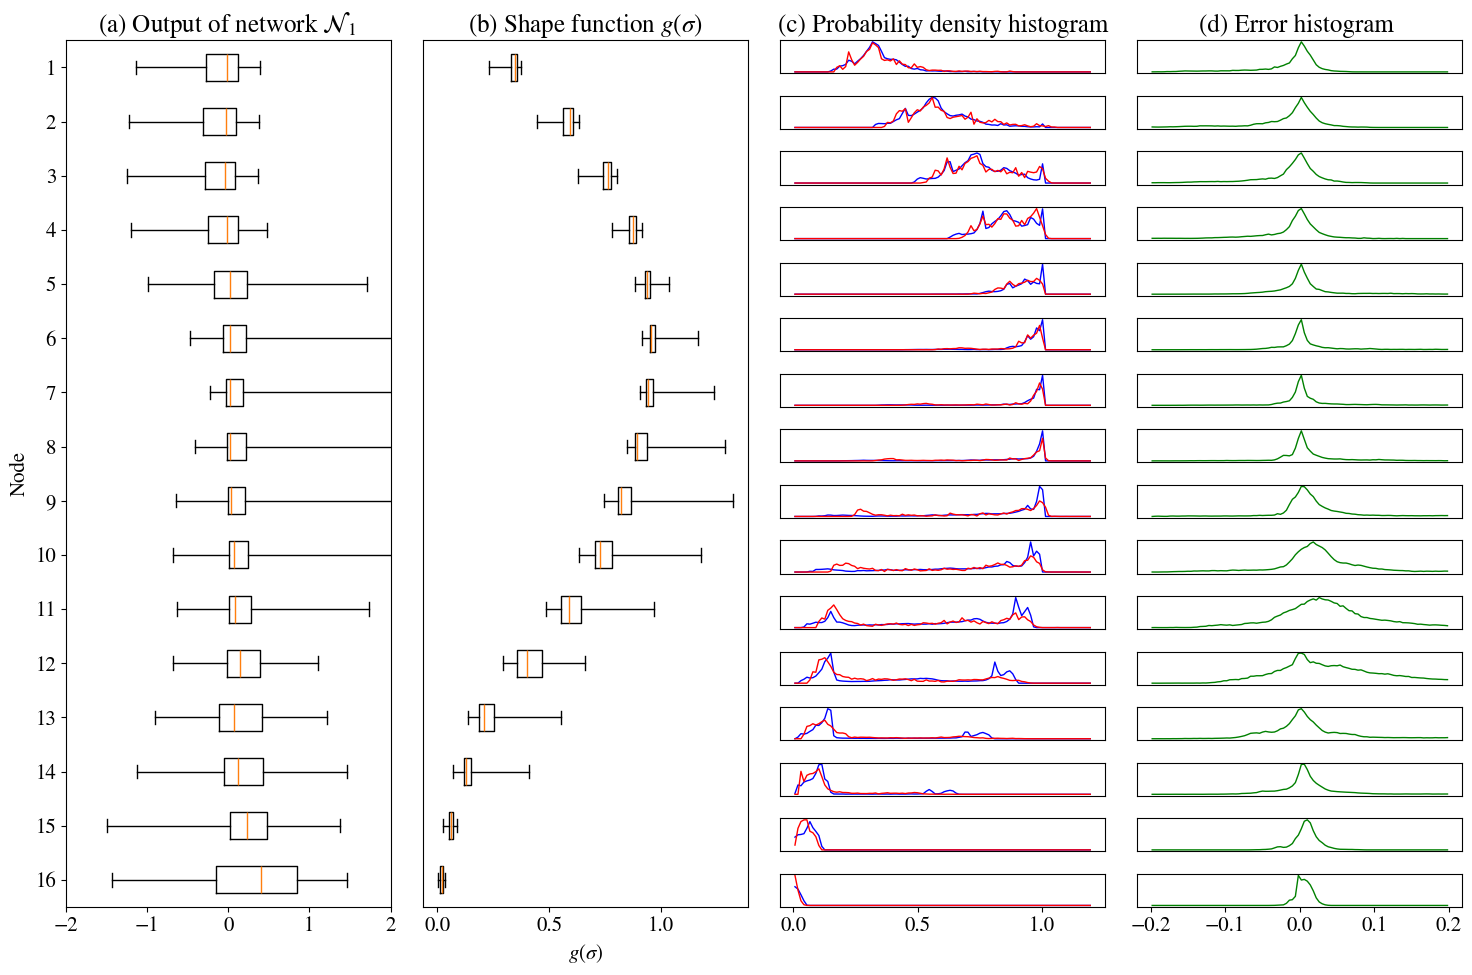

In [35]:
import torch
import numpy as np
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Convert tensors to numpy arrays (XGBoost only accepts numpy)
x_np = x_original.detach().cpu().numpy()
y_np = y_original.detach().cpu().numpy()
valid_x_np = valid_x_original.detach().cpu().numpy()
valid_y_np = valid_y_original.detach().cpu().numpy()

# Initialize and train the XGBoost model
xgb_base = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=1
)

xgb_multi_model = MultiOutputRegressor(xgb_base)
xgb_multi_model.fit(x_np, y_np)

# Define a wrapper class to make XGBoost compatible with PyTorch-style interface
class XGBWrapper(torch.nn.Module):
    def __init__(self, model_xgb, k_mean, k_std):
        super().__init__()
        self.model_xgb = model_xgb
        self.k_mean = torch.tensor(k_mean).float()
        self.k_std = torch.tensor(k_std).float()

    def forward(self, x):
        x_np = x.detach().cpu().numpy()
        y_pred = self.model_xgb.predict(x_np)
        y_pred = torch.tensor(y_pred).float()
        return y_pred

# Wrap the XGBoost model and run evaluation
model_xgb_wrap = XGBWrapper(xgb_multi_model, k_mean, k_std).to(device)

performance_sigma_point(model_xgb_wrap, x_original, valid_x, y_original, valid_y, k_mean, k_std)

In [ ]:
# ==== Setup: Manually select input features ====
# Assume the original input order is ['l0', 'b0', 'ustar0', 'h0']
var_idx = {'l0': 0, 'b0': 1, 'ustar0': 2, 'h0': 3}
chosen_vars = ['b0', 'ustar0', 'h0']  # ✅ Custom input combination
indices = [var_idx[v] for v in chosen_vars]

# ==== Select columns from existing Tensors ====
x_sel = x_original[:, indices]
valid_x_sel = valid_x[:, indices]

# Convert to numpy arrays for XGBoost
x_np = x_sel.detach().cpu().numpy()
y_np = y.detach().cpu().numpy()
valid_x_np = valid_x_sel.detach().cpu().numpy()
valid_y_np = valid_y.detach().cpu().numpy()

# ==== Initialize and train multi-output XGBoost model ====
xgb_base = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_multi_model = MultiOutputRegressor(xgb_base)
xgb_multi_model.fit(x_np, y_np)

# ==== Define a wrapper to make it compatible with performance_sigma_point ====
class XGBWrapper(torch.nn.Module):
    def __init__(self, model_xgb, k_mean, k_std):
        super().__init__()
        self.model_xgb = model_xgb
        self.k_mean = torch.tensor(k_mean).float()
        self.k_std = torch.tensor(k_std).float()

    def forward(self, x):
        x_np = x.detach().cpu().numpy()
        y_pred = self.model_xgb.predict(x_np)
        y_pred = torch.tensor(y_pred).float()
        return y_pred

# ==== Build the wrapper model ====
model_xgb_wrap = XGBWrapper(xgb_multi_model, k_mean, k_std).to(device)

# ✅ Visualize model prediction performance (your existing function)
performance_sigma_point(model_xgb_wrap, x_sel, valid_x_sel, y, valid_y, k_mean, k_std)